# 🎯 DCA Polymarket Backtesting v11

A modular backtesting framework for DCA strategies on Polymarket prediction markets.

**Features:**
- Multi-tier DCA entry strategy
- Stop-loss and take-profit management
- Optuna hyperparameter optimization
- Market analysis and visualization

**Expected data columns:** `datetime, asset_id, market_id, ob_best_bid, ob_best_ask, ob_mid_price, orderbook_bids, orderbook_asks`

---

## Table of Contents
1. [Setup & Imports](#1-setup--imports)
2. [Data Loading](#2-data-loading)
3. [Core Functions](#3-core-functions)
4. [Backtest Engine](#4-backtest-engine)
5. [Visualization](#5-visualization)
6. [Optuna Optimizer](#6-optuna-optimizer)
7. [Market Analysis](#7-market-analysis)
8. [Known Winners](#8-known-winners)
9. [Run Backtest](#9-run-backtest)
10. [Run Optimization](#10-run-optimization)

---
## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import json
import warnings
from typing import Dict, List, Optional, Tuple
from collections import defaultdict

warnings.filterwarnings('ignore')
print("✅ Core imports ready")

✅ Core imports ready


In [2]:
# Visualization imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Visualization imports ready")

✅ Visualization imports ready


In [3]:
!pip3 install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 8.1 MB/s eta 0:00:00


In [4]:
# Optional: Optuna for optimization
try:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    OPTUNA_AVAILABLE = True
    print("✅ Optuna ready")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("⚠️ Optuna not installed - optimization disabled")
    print("   Install with: pip install optuna")

✅ Optuna ready


---
## 2. Data Loading

In [5]:
# Mount Google Drive (Colab only)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    print("✅ Google Drive mounted")
except:
    IN_COLAB = False
    print("ℹ️ Not running in Colab - skipping Drive mount")

Mounted at /content/drive
✅ Google Drive mounted


In [6]:
!cp "/content/drive/MyDrive/Archive.zip" .
!unzip Archive.zip -d extracted


Archive:  Archive.zip
  inflating: extracted/snapshots_27jan_reconstructed.parquet  
  inflating: extracted/__MACOSX/._snapshots_27jan_reconstructed.parquet  
  inflating: extracted/snapshots_24jan_reconstructed.parquet  
  inflating: extracted/__MACOSX/._snapshots_24jan_reconstructed.parquet  
  inflating: extracted/snapshots_26jan_reconstructed.parquet  
  inflating: extracted/__MACOSX/._snapshots_26jan_reconstructed.parquet  
  inflating: extracted/snapshots_25jan_reconstructed.parquet  
  inflating: extracted/__MACOSX/._snapshots_25jan_reconstructed.parquet  


In [41]:
# Configure your data paths here
DATA_PATHS = {
    '24jan': 'extracted/snapshots_24jan_reconstructed.parquet',
    '25jan': 'extracted/snapshots_25jan_reconstructed.parquet',
    '26jan': 'extracted/snapshots_26jan_reconstructed.parquet',
    '27jan': 'extracted/snapshots_27jan_reconstructed.parquet',
    '01feb': 'snapshots_1feb_reconstructed.parquet',
}

# If using Google Drive, update paths:
# DATA_PATHS = {
#     '24jan': '/content/drive/MyDrive/your_folder/snapshots_24jan_reconstructed.parquet',
#     ...
# }

In [8]:
def load_data(path: str) -> pd.DataFrame:
    """Load and validate parquet data."""
    df = pd.read_parquet(path)
    df['datetime'] = pd.to_datetime(df['datetime'])

    required_cols = ['datetime', 'asset_id', 'market_id', 'ob_best_bid', 'ob_best_ask']
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    print(f"✅ Loaded {len(df):,} rows, {df['market_id'].nunique()} markets")
    print(f"   Time range: {df['datetime'].min()} to {df['datetime'].max()}")
    return df


def list_markets(df: pd.DataFrame):
    """Display available markets in the dataframe."""
    markets = df['market_id'].unique()
    print(f"\n📋 {len(markets)} Markets:")
    for i, m in enumerate(markets):
        n = len(df[df['market_id'] == m])
        print(f"  {i}: {m[:50]}... ({n:,} rows)")

In [9]:
# Example: Load one dataset
# df = load_data(DATA_PATHS['25jan'])
# list_markets(df)

---
## 3. Core Functions

Orderbook parsing and trade execution logic.

In [10]:
def parse_orderbook_levels(json_str: str) -> List[Dict]:
    """Parse orderbook levels from JSON string."""
    if not json_str or pd.isna(json_str):
        return []
    try:
        return json.loads(json_str)
    except:
        return []

In [11]:
def execute_buy(asks_json: str, amount_usd: float) -> Tuple[float, float, float]:
    """
    Execute buy order against asks.

    Args:
        asks_json: JSON string of ask levels
        amount_usd: Amount to spend in USD

    Returns:
        (shares_bought, total_cost, avg_price)
    """
    asks = parse_orderbook_levels(asks_json)
    if not asks or amount_usd <= 0:
        return 0, 0, 0

    shares, cost, remaining = 0, 0, amount_usd
    for level in asks:
        if remaining <= 0:
            break
        p, s = level['price'], level['size']
        take = min(s, remaining / p)
        shares += take
        cost += take * p
        remaining -= take * p

    return shares, cost, cost / shares if shares > 0 else 0

In [12]:
def execute_sell(bids_json: str, shares_to_sell: float) -> Tuple[float, float, float]:
    """
    Execute sell order against bids.

    Args:
        bids_json: JSON string of bid levels
        shares_to_sell: Number of shares to sell

    Returns:
        (shares_sold, total_proceeds, avg_price)
    """
    bids = parse_orderbook_levels(bids_json)
    if not bids or shares_to_sell <= 0:
        return 0, 0, 0

    sold, proceeds, remaining = 0, 0, shares_to_sell
    for level in bids:
        if remaining <= 0:
            break
        p, s = level['price'], level['size']
        take = min(s, remaining)
        sold += take
        proceeds += take * p
        remaining -= take

    return sold, proceeds, proceeds / sold if sold > 0 else 0


print("✅ Core functions ready")

✅ Core functions ready


---
## 4. Backtest Engine

The main DCA backtesting logic with configurable parameters.

In [13]:
# Default strategy parameters

DEFAULT_PARAMS = {
    'cooldown_periods': 6,
    'dca_tier_1': 0.9639,
    'dca_tier_2': 0.9744,
    'dca_tier_3': 0.9958,
    'entry_threshold': 0.9603,
    'exit_stop_loss': 0.7889,
    'stop_loss_pct': 0.1400,
    'take_profit_pct': 0.0350,
    'weight_entry': 0.4899,
    'weight_tier_1': 0.2783,
    'weight_tier_2': 0.1002,
    'weight_tier_3': 0.0572,
}


def normalize_params(params: Dict) -> Dict:
    """Normalize parameters with defaults and weight normalization."""
    p = DEFAULT_PARAMS.copy()
    p.update(params or {})

    # Normalize weights to sum to 1
    w_keys = ['weight_entry', 'weight_tier_1', 'weight_tier_2', 'weight_tier_3']
    total = sum(p[k] for k in w_keys)
    for k in w_keys:
        p[k] /= total
    return p

In [14]:
"""
DCA Backtest Engine v15

Features:
1. Late-game stop loss disable (after 90% market progress)
2. EARLY HEDGE - can trigger anytime on:
   a) Fast drop: X points in Y seconds (catches flash crashes)
   b) NEW: Slow drop: X points from entry price (catches slow bleeds)
3. Once hedged, SL disabled on main position
4. Grace period after entry - no SL for X seconds after buying
5. Hedge promotion rules (hedge outperforms → close main, promote hedge)
"""

def run_backtest(
    df: pd.DataFrame,
    params: Dict = None,
    known_winners: Dict = None,
    initial_capital: float = 500,
    global_tp_pct: float = 0.20,
    selected_markets: List = None,
    resample: str = '1s',
    verbose: bool = True,
    # Late-game parameters
    late_game_threshold: float = 0.90,
    # Trading window restriction
    last_minutes_only: int = 10,          # NEW: Only trade in last X minutes (None = trade anytime)
    # Hedge parameters - FAST DROP
    hedge_enabled: bool = True,
    hedge_drop_points: float = 0.12,        # Fast drop: 12 points in window (was 0.08)
    hedge_drop_window: int = 90,            # Fast drop: 90 seconds (was 120)
    # Hedge parameters - SLOW DROP
    hedge_drop_from_entry: float = 0.10,    # Slow drop: 10 points from entry (was 0.06)
    # Hedge general
    hedge_amount: float = 30.0,
    hedge_late_game_only: bool = True,      # CHANGED: Only hedge in late game (was False)
    # Grace period
    entry_grace_period: int = 180,
    # Hedge PROMOTION parameters
    hedge_promotion_pnl_pct: float = 0.20,
    hedge_promotion_price: float = 0.30,
    hedge_promotion_delta: float = 0.15,
    # Instant exit
    instant_exit_price: float = 0.99,       # Exit ANY position instantly at this price
    # Noise filtering
    max_spread_for_sl: float = 0.10,        # Ignore tick for SL if spread > this
    sl_confirmation_ticks: int = 5,         # Need X consecutive ticks below SL to trigger
) -> Dict:
    """
    Run DCA backtest with dual hedge triggers.

    HEDGE TRIGGERS (either one):
    1. FAST DROP: Price drops >= hedge_drop_points within hedge_drop_window seconds
    2. SLOW DROP: Price drops >= hedge_drop_from_entry from average entry price

    This catches both:
    - Flash crashes (fast drop)
    - Slow bleeds (drop from entry)

    Args:
        df: DataFrame with orderbook columns
        params: Strategy parameters
        known_winners: Dict of market_id -> winning asset_id
        initial_capital: Starting capital in USD
        global_tp_pct: Global take profit as % of capital
        selected_markets: List of market IDs to include
        resample: Resample interval
        verbose: Print progress
        late_game_threshold: % progress after which SL disabled
        last_minutes_only: Only allow entries in last X minutes of market (None = trade anytime)
        hedge_enabled: Enable hedging
        hedge_drop_points: Fast drop threshold (points)
        hedge_drop_window: Fast drop time window (seconds)
        hedge_drop_from_entry: Slow drop threshold from entry price
        hedge_amount: USD to hedge with
        hedge_late_game_only: If False, hedge can trigger anytime
        entry_grace_period: Seconds after entry where SL is disabled
        hedge_promotion_pnl_pct: Promote if hedge P&L >= X% of main cost
        hedge_promotion_price: Promote if hedge price >= this
        hedge_promotion_delta: Promote if hedge outperforms main by this %
        instant_exit_price: Exit ANY position instantly when bid >= this (default 0.99)
        max_spread_for_sl: Ignore tick for SL/hedge if spread > this (filters noise)
        sl_confirmation_ticks: Require X consecutive ticks below SL to trigger
    """
    params = normalize_params(params)

    # Prepare data
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')
    df = df[df['ob_best_bid'].notna() & df['ob_best_ask'].notna()].copy()

    # Market selection
    if selected_markets is not None:
        all_markets = df['market_id'].unique()
        sel = [all_markets[m] if isinstance(m, int) and m < len(all_markets) else m
               for m in selected_markets]
        df = df[df['market_id'].isin(sel)]

    if verbose:
        print(f"📊 {df['market_id'].nunique()} markets, {len(df):,} rows")

    # Resample if requested
    if resample:
        df['bucket'] = df['datetime'].dt.floor(resample)
        df = df.groupby(['market_id', 'asset_id', 'bucket']).last().reset_index()
        df = df.drop(columns=['datetime']).rename(columns={'bucket': 'datetime'})
        df = df.sort_values('datetime')
        if verbose:
            print(f"⏱️  Resampled to {resample}: {len(df):,} rows")

    # Calculate market time bounds
    market_times = {}
    for mid in df['market_id'].unique():
        mdf = df[df['market_id'] == mid]
        market_times[mid] = {
            'start': mdf['datetime'].min(),
            'end': mdf['datetime'].max(),
            'duration': (mdf['datetime'].max() - mdf['datetime'].min()).total_seconds()
        }

    # Extract parameters
    ENTRY = params['entry_threshold']
    EXIT_SL = params['exit_stop_loss']
    SL_PCT = params['stop_loss_pct']
    TP_PCT = params['take_profit_pct']
    COOLDOWN = params['cooldown_periods']
    GLOBAL_TP = initial_capital * global_tp_pct

    DCA_TIERS = [
        ('entry', ENTRY, params['weight_entry']),
        ('tier_1', params['dca_tier_1'], params['weight_tier_1']),
        ('tier_2', params['dca_tier_2'], params['weight_tier_2']),
        ('tier_3', params['dca_tier_3'], params['weight_tier_3']),
    ]

    # Initialize market state
    markets = df['market_id'].unique()
    cap_per = initial_capital / len(markets)
    state = {
        m: {
            'alloc': cap_per,
            'cash': cap_per,
            'pos': {},
            'active': None,
            'tiers': set(),
            'pnl': 0,
            'cooldown': {},
            'sl_count': 0,
            'tp_count': 0,
            'price_history': {},
            'last_entry_time': {},
            # Hedge tracking
            'hedge_asset': None,
            'main_asset': None,
            'promoted': False,
            'promotion_reason': None,
            # 0.99 exit tracking
            'hit_99': False,
            # SL confirmation tracking
            'sl_below_count': {},  # {asset_id: consecutive ticks below SL}
        }
        for m in markets
    }

    all_trades = []
    price_cache = {}
    global_tp_hit = False
    global_tp_ts = None

    # Main simulation loop
    for _, row in df.iterrows():
        if global_tp_hit:
            break

        aid = row['asset_id']
        mid = row['market_id']
        ts = row['datetime']
        best_bid = row['ob_best_bid']
        best_ask = row['ob_best_ask']
        bids_json = row.get('orderbook_bids', '[]')
        asks_json = row.get('orderbook_asks', '[]')

        s = state[mid]
        current_price = (best_bid + best_ask) / 2
        price_cache[(mid, aid)] = current_price
        has_pos = aid in s['pos'] and s['pos'][aid]['shares'] > 0

        is_hedge = (aid == s['hedge_asset'])
        is_main = (aid == s['main_asset'])
        has_hedge = s['hedge_asset'] is not None

        # Calculate market progress
        mt = market_times[mid]
        if mt['duration'] > 0:
            elapsed = (ts - mt['start']).total_seconds()
            market_progress = min(elapsed / mt['duration'], 1.0)
        else:
            market_progress = 1.0

        in_late_game = market_progress >= late_game_threshold

        # Check if we're in the trading window (last X minutes)
        in_trading_window = True
        if last_minutes_only is not None:
            time_remaining = mt['duration'] - elapsed
            in_trading_window = time_remaining <= (last_minutes_only * 60)

        # Check grace period
        in_grace_period = False
        if aid in s['last_entry_time']:
            time_since_entry = (ts - s['last_entry_time'][aid]).total_seconds()
            in_grace_period = time_since_entry < entry_grace_period

        # Track price history
        if aid not in s['price_history']:
            s['price_history'][aid] = []
        s['price_history'][aid].append((ts, current_price))
        cutoff_time = ts - pd.Timedelta(seconds=300)
        s['price_history'][aid] = [(t, p) for t, p in s['price_history'][aid] if t >= cutoff_time]

        # Global P&L check
        total_pnl = sum(st['pnl'] for st in state.values())
        total_pnl += sum(
            price_cache.get((m, a), 0) * p['shares'] - p['cost']
            for m, st in state.items()
            for a, p in st['pos'].items() if p['shares'] > 0
        )

        # Global take profit
        if total_pnl >= GLOBAL_TP:
            global_tp_hit = True
            global_tp_ts = ts
            for m, st in state.items():
                for a, p in st['pos'].items():
                    if p['shares'] > 0:
                        price = price_cache.get((m, a), 0.5)
                        proceeds = p['shares'] * price
                        pnl = proceeds - p['cost']
                        st['pnl'] += pnl
                        st['cash'] += proceeds
                        all_trades.append({
                            'ts': ts, 'market': m, 'asset': a,
                            'action': 'SELL', 'reason': 'GLOBAL_TP', 'pnl': pnl
                        })
            break

        # =================================================================
        # HEDGE PROMOTION CHECK
        # =================================================================
        if s['hedge_asset'] and s['main_asset'] and not s['promoted']:
            hedge_aid = s['hedge_asset']
            main_aid = s['main_asset']

            hedge_pos = s['pos'].get(hedge_aid, {'shares': 0, 'cost': 0})
            main_pos = s['pos'].get(main_aid, {'shares': 0, 'cost': 0})

            if hedge_pos['shares'] > 0 and main_pos['shares'] > 0:
                hedge_price = price_cache.get((mid, hedge_aid), 0)
                main_price = price_cache.get((mid, main_aid), 0)

                hedge_value = hedge_pos['shares'] * hedge_price
                hedge_pnl = hedge_value - hedge_pos['cost']
                hedge_return = hedge_pnl / hedge_pos['cost'] if hedge_pos['cost'] > 0 else 0

                main_value = main_pos['shares'] * main_price
                main_pnl = main_value - main_pos['cost']
                main_return = main_pnl / main_pos['cost'] if main_pos['cost'] > 0 else 0

                promote = False
                reason = None

                if hedge_pnl >= hedge_promotion_pnl_pct * main_pos['cost']:
                    promote = True
                    reason = f'HEDGE_PNL_{hedge_pnl:.2f}>={hedge_promotion_pnl_pct*100:.0f}%_MAIN'
                elif hedge_price >= hedge_promotion_price:
                    promote = True
                    reason = f'HEDGE_PRICE_{hedge_price:.2f}>={hedge_promotion_price}'
                elif hedge_return - main_return >= hedge_promotion_delta:
                    promote = True
                    reason = f'HEDGE_DELTA_{(hedge_return-main_return)*100:.1f}%>={hedge_promotion_delta*100:.0f}%'

                if promote:
                    if verbose:
                        print(f"🔄 PROMOTION [{mid[:20]}...]: {reason}")
                        print(f"   Main: ${main_pnl:+.2f} ({main_return*100:+.1f}%) @ {main_price:.2f}")
                        print(f"   Hedge: ${hedge_pnl:+.2f} ({hedge_return*100:+.1f}%) @ {hedge_price:.2f}")

                    # Close main position
                    main_bids = df[(df['market_id'] == mid) &
                                   (df['asset_id'] == main_aid) &
                                   (df['datetime'] <= ts)]
                    if len(main_bids) > 0:
                        main_bids_json = main_bids.iloc[-1].get('orderbook_bids', '[]')
                        sold, proceeds, _ = execute_sell(main_bids_json, main_pos['shares'])
                        if sold > 0:
                            pnl = proceeds - main_pos['cost']
                            s['pnl'] += pnl
                            s['cash'] += proceeds
                            s['pos'][main_aid] = {'shares': 0, 'cost': 0}

                            all_trades.append({
                                'ts': ts, 'market': mid, 'asset': main_aid,
                                'action': 'SELL', 'reason': 'PROMOTION_CLOSE_MAIN',
                                'pnl': pnl
                            })

                    s['promoted'] = True
                    s['promotion_reason'] = reason
                    s['main_asset'] = hedge_aid
                    s['hedge_asset'] = None
                    s['active'] = hedge_aid

        # =================================================================
        # HEDGE TRIGGER - DUAL CHECK (Fast drop OR Slow drop from entry)
        # Requires clean tick (not noisy spread)
        # Check on MAIN ASSET's row only
        # IMPORTANT: Check hedge BEFORE exit logic - hedge takes priority over SL
        # =================================================================
        spread = best_ask - best_bid
        tick_is_noisy = spread > max_spread_for_sl

        # We need to check hedge on the main asset, not just any asset we have a position in
        main_aid = s['main_asset']
        has_main_pos = main_aid and main_aid in s['pos'] and s['pos'][main_aid]['shares'] > 0
        is_main_row = (aid == main_aid)  # Are we processing the main asset's row?

        # DEBUG: Show position status periodically
        if verbose and has_pos and market_progress > 0.5 and int(ts.timestamp()) % 60 == 0:
            print(f"   [DEBUG POS] {mid[:15]}... aid={aid[:10]} main_aid={str(main_aid)[:10] if main_aid else 'None'} has_main_pos={has_main_pos} is_main_row={is_main_row} price={current_price:.2f}")

        can_hedge = (hedge_enabled and has_main_pos and not s['hedge_asset'] and
                     not s['promoted'] and is_main_row and not s['hit_99'] and not tick_is_noisy)

        # DEBUG: Why can't we hedge?
        if has_main_pos and is_main_row and not can_hedge and verbose:
            reasons = []
            if not hedge_enabled: reasons.append("hedge_disabled")
            if s['hedge_asset']: reasons.append("already_hedged")
            if s['promoted']: reasons.append("promoted")
            if s['hit_99']: reasons.append("hit_99")
            if tick_is_noisy: reasons.append(f"noisy_spread_{spread:.2f}")
            if reasons:
                print(f"   [DEBUG] Can't hedge {mid[:15]}...: {', '.join(reasons)}")

        if hedge_late_game_only and not in_late_game:
            can_hedge = False

        hedge_triggered_this_tick = False  # Track if we just hedged

        if can_hedge:
            trigger_hedge = False
            hedge_reason = ""

            # Get main position info
            main_pos = s['pos'].get(aid, {'shares': 0, 'cost': 0})
            if main_pos['shares'] > 0:
                avg_entry = main_pos['cost'] / main_pos['shares']

                # ---------------------------------------------------------
                # CHECK 1: FAST DROP (X points in Y seconds)
                # ---------------------------------------------------------
                history = s['price_history'][aid]
                if len(history) >= 2:
                    window_start = ts - pd.Timedelta(seconds=hedge_drop_window)
                    old_prices = [(t, p) for t, p in history if t <= window_start]

                    if old_prices:
                        old_price = old_prices[-1][1]
                        fast_drop = old_price - current_price

                        if fast_drop >= hedge_drop_points:
                            trigger_hedge = True
                            hedge_reason = f"FAST_DROP_{fast_drop:.2f}_in_{hedge_drop_window}s"

                # ---------------------------------------------------------
                # CHECK 2: SLOW DROP (X points from entry price)
                # ---------------------------------------------------------
                if not trigger_hedge:
                    drop_from_entry = avg_entry - current_price

                    if drop_from_entry >= hedge_drop_from_entry:
                        trigger_hedge = True
                        hedge_reason = f"SLOW_DROP_{drop_from_entry:.2f}_from_entry_{avg_entry:.2f}"

                # DEBUG: Print when we're checking hedge but not triggering
                if not trigger_hedge and drop_from_entry > 0.05:
                    if verbose:
                        print(f"   [DEBUG HEDGE] {mid[:15]}... price={current_price:.2f} entry={avg_entry:.2f} drop={drop_from_entry:.2f} need={hedge_drop_from_entry}")

            # ---------------------------------------------------------
            # EXECUTE HEDGE
            # ---------------------------------------------------------
            if trigger_hedge:
                all_assets = df[df['market_id'] == mid]['asset_id'].unique()
                opposite_assets = [a for a in all_assets if a != aid]

                if opposite_assets and s['cash'] >= hedge_amount:
                    opp_aid = opposite_assets[0]
                    opp_rows = df[(df['market_id'] == mid) &
                                 (df['asset_id'] == opp_aid) &
                                 (df['datetime'] <= ts)]

                    if len(opp_rows) > 0:
                        opp_row = opp_rows.iloc[-1]
                        opp_asks = opp_row.get('orderbook_asks', '[]')

                        shares, cost, avg_p = execute_buy(opp_asks, hedge_amount)
                        if shares > 0:
                            if opp_aid not in s['pos']:
                                s['pos'][opp_aid] = {'shares': 0, 'cost': 0}
                            s['pos'][opp_aid]['shares'] += shares
                            s['pos'][opp_aid]['cost'] += cost
                            s['cash'] -= cost

                            s['hedge_asset'] = opp_aid
                            s['main_asset'] = aid
                            hedge_triggered_this_tick = True  # Mark that we just hedged

                            all_trades.append({
                                'ts': ts, 'market': mid, 'asset': opp_aid,
                                'action': 'BUY', 'reason': 'HEDGE',
                                'cost': cost, 'shares': shares
                            })

                            if verbose:
                                print(f"🛡️ HEDGE [{mid[:20]}...]: {hedge_reason}")
                                print(f"   Bought ${cost:.2f} @ {avg_p:.2f} | Main @ {current_price:.2f}")

        # =================================================================
        # EXIT LOGIC
        # =================================================================
        if has_pos:
            p = s['pos'][aid]
            if p['shares'] <= 0:
                continue  # Skip if position was just closed (e.g., by promotion)
            avg = p['cost'] / p['shares']
            exit_reason = None

            # Calculate spread for noise filtering
            spread = best_ask - best_bid
            tick_is_noisy = spread > max_spread_for_sl

            # Check if we have an active hedge (including one just triggered)
            has_hedge_now = s['hedge_asset'] is not None

            # ---------------------------------------------------------
            # INSTANT EXIT AT 0.99 - applies to ALL positions (no spread filter)
            # ---------------------------------------------------------
            if best_bid >= instant_exit_price:
                exit_reason = 'EXIT_99'
                s['hit_99'] = True

            # HEDGE positions: NO TP/SL
            elif is_hedge:
                pass

            # PROMOTED positions: NO TP/SL
            elif s['promoted']:
                pass

            # MAIN positions with active hedge: NO SL (hedge is protection)
            elif has_hedge_now and is_main:
                # Only TP still active (no spread filter for TP)
                if best_bid >= avg * (1 + TP_PCT):
                    exit_reason = 'TAKE_PROFIT'

            # MAIN positions: normal logic with grace period and late-game check
            else:
                sl_active = True

                if in_late_game:
                    sl_active = False
                if in_grace_period:
                    sl_active = False

                # ---------------------------------------------------------
                # STOP LOSS with spread filter + confirmation ticks
                # ---------------------------------------------------------
                if sl_active and not tick_is_noisy:
                    # Check if price is below SL thresholds
                    below_sl = False
                    sl_type = None

                    if best_bid < EXIT_SL:
                        below_sl = True
                        sl_type = 'STOP_LOSS_ABS'
                    elif best_bid < avg * (1 - SL_PCT):
                        below_sl = True
                        sl_type = 'STOP_LOSS_PCT'

                    if below_sl:
                        # Increment confirmation counter
                        if aid not in s['sl_below_count']:
                            s['sl_below_count'][aid] = 0
                        s['sl_below_count'][aid] += 1

                        # Only trigger if enough consecutive ticks
                        if s['sl_below_count'][aid] >= sl_confirmation_ticks:
                            exit_reason = sl_type
                    else:
                        # Reset counter if price back above SL
                        s['sl_below_count'][aid] = 0
                elif tick_is_noisy:
                    # Don't reset counter on noisy ticks, just ignore them
                    pass

                # TP always active (no spread filter for TP)
                if best_bid >= avg * (1 + TP_PCT):
                    exit_reason = 'TAKE_PROFIT'

            if exit_reason:
                sold, proceeds, _ = execute_sell(bids_json, p['shares'])
                if sold > 0:
                    pnl = proceeds - p['cost']
                    s['pnl'] += pnl
                    s['cash'] += proceeds
                    s['pos'][aid] = {'shares': 0, 'cost': 0}

                    if is_main or (not s['hedge_asset'] and not s['promoted']):
                        s['active'] = None
                        s['tiers'] = set()

                    s['cooldown'][aid] = ts + pd.Timedelta(seconds=30 * COOLDOWN)
                    if 'STOP' in exit_reason:
                        s['sl_count'] += 1
                    else:
                        s['tp_count'] += 1
                    all_trades.append({
                        'ts': ts, 'market': mid, 'asset': aid,
                        'action': 'SELL', 'reason': exit_reason, 'pnl': pnl
                    })
                continue

        # Cooldown check
        if aid in s['cooldown']:
            if ts < s['cooldown'][aid]:
                continue
            del s['cooldown'][aid]

        # =================================================================
        # ENTRY/DCA LOGIC
        # =================================================================
        # Block all entries if this market already hit 0.99
        if s['hit_99']:
            continue

        # Block entries if not in trading window (last_minutes_only mode)
        if not in_trading_window:
            continue

        if best_ask >= ENTRY and not s['promoted']:
            if s['active'] is None:
                s['active'] = aid
                s['main_asset'] = aid

            if s['active'] == aid:
                for tier, thresh, weight in DCA_TIERS:
                    if tier in s['tiers'] or best_ask < thresh:
                        continue

                    amt = min(s['alloc'] * weight, s['cash'])
                    if amt <= 1:
                        continue

                    shares, cost, avg_p = execute_buy(asks_json, amt)
                    if shares > 0:
                        if aid not in s['pos']:
                            s['pos'][aid] = {'shares': 0, 'cost': 0}
                        s['pos'][aid]['shares'] += shares
                        s['pos'][aid]['cost'] += cost
                        s['cash'] -= cost
                        s['tiers'].add(tier)

                        s['last_entry_time'][aid] = ts

                        all_trades.append({
                            'ts': ts, 'market': mid, 'asset': aid,
                            'action': 'BUY', 'reason': tier,
                            'cost': cost, 'shares': shares
                        })
                        break

    # =================================================================
    # MARKET CLOSE
    # =================================================================
    if not global_tp_hit:
        for mid, s in state.items():
            for aid, p in s['pos'].items():
                if p['shares'] > 0:
                    if known_winners and mid in known_winners:
                        close_price = 1.0 if aid == known_winners[mid] else 0.0
                    else:
                        close_price = price_cache.get((mid, aid), 0.5)

                    proceeds = p['shares'] * close_price
                    pnl = proceeds - p['cost']
                    s['pnl'] += pnl
                    s['cash'] += proceeds

                    reason = 'MARKET_CLOSE'
                    if aid == s.get('hedge_asset'):
                        reason = 'MARKET_CLOSE_HEDGE'
                    elif s['promoted'] and aid == s.get('main_asset'):
                        reason = 'MARKET_CLOSE_PROMOTED'

                    all_trades.append({
                        'ts': None, 'market': mid, 'asset': aid,
                        'action': 'SELL', 'reason': reason, 'pnl': pnl
                    })

    # =================================================================
    # RESULTS
    # =================================================================
    final_value = sum(s['cash'] for s in state.values())
    total_pnl = sum(s['pnl'] for s in state.values())
    trades_df = pd.DataFrame(all_trades) if all_trades else pd.DataFrame()

    if len(trades_df) > 0 and 'pnl' in trades_df.columns:
        wins = len(trades_df[trades_df['pnl'] > 0])
        losses = len(trades_df[trades_df['pnl'] < 0])
    else:
        wins, losses = 0, 0

    if len(trades_df) > 0 and 'reason' in trades_df.columns:
        hedge_count = len(trades_df[trades_df['reason'] == 'HEDGE'])
        promotion_count = len(trades_df[trades_df['reason'] == 'PROMOTION_CLOSE_MAIN'])
    else:
        hedge_count, promotion_count = 0, 0

    results = {
        'total_return': (final_value - initial_capital) / initial_capital,
        'total_pnl': total_pnl,
        'final_value': final_value,
        'wins': wins,
        'losses': losses,
        'win_rate': wins / (wins + losses) if (wins + losses) > 0 else 0,
        'sl_count': sum(s['sl_count'] for s in state.values()),
        'tp_count': sum(s['tp_count'] for s in state.values()),
        'hedge_count': hedge_count,
        'promotion_count': promotion_count,
        'global_tp_hit': global_tp_hit,
        'global_tp_ts': global_tp_ts,
        'trades': trades_df,
        'market_state': state,
        'params': params,
    }

    if verbose:
        print("\n" + "=" * 50)
        print("💰 RESULTS")
        print("=" * 50)
        print(f"Capital: ${initial_capital:.2f} → ${final_value:.2f} ({results['total_return']*100:+.1f}%)")
        print(f"P&L: ${total_pnl:+.2f} | Win Rate: {results['win_rate']*100:.0f}%")
        print(f"Wins: {wins} | Losses: {losses} | SL: {results['sl_count']} | TP: {results['tp_count']}")
        if hedge_count > 0:
            print(f"🛡️ Hedges: {hedge_count} | Promotions: {promotion_count}")
        if global_tp_hit:
            print(f"🎯 Global TP hit at {global_tp_ts}")
        print("\n📋 Per Market:")
        for i, (m, s) in enumerate(state.items()):
            status = ""
            if s['promoted']:
                status = f" [PROMOTED]"
            elif s['hedge_asset']:
                status = " [HEDGED]"
            print(f"   {i}: ${s['pnl']:+.2f}{status}")

    return results


print("✅ Backtest engine v15 ready")
print("   DUAL HEDGE TRIGGERS:")
print("   1. Fast drop: hedge_drop_points in hedge_drop_window")
print("   2. Slow drop: hedge_drop_from_entry from avg entry price")

✅ Backtest engine v15 ready
   DUAL HEDGE TRIGGERS:
   1. Fast drop: hedge_drop_points in hedge_drop_window
   2. Slow drop: hedge_drop_from_entry from avg entry price


In [15]:
df = load_data(DATA_PATHS['24jan'])



selected_markets_27jan = {
    '0xdc61b928589ea4d3e97bbb80a27e84eca4f59cfa9c37319ba2a7b63199bcdf31': '114810619020440066196286636298926087160454506616717843900975576221717806376761',
    '0xb358099a4d3cd1908fafa4ef492d131a4d30a41866b556ac65ea0db905ec78a1': '48924055834814888428606569679658798321783136070365706735814433351016547108906',
    '0x4e99e7565b30f92229489999e659a3136632449d88fc011bd4e8cc06c484ccca': '87890321414384780337490094423156067406932290358906185528607515117644478595310',
    '0x538be58810bd07707c1e849da9b4de12dc6617739c2e87043ea9b7fb2b6266c3': '41247652063966004401306857419416685235874842651432515489339067969075836389387',
    '0xcbed61cd2f96e0137ad098dcd8941efedea6f2e304f8b786f2a177ffffa9328a': '27061289282536287632793183240411687357181345607670439418333463229431698897460',
    '0x42c36cff27c928a58f71626244fb1acebcfd963976972cc03dc46c809a8663da': '41882622457175161594434643470609594422739676193078727425608733682888208989127',
    '0xbf399bc9894b502586ad0ed7383fffcadb07c21c507fb2a84a991741763a8efc': '35923522612276750394651557626496020946647566899591212994355411047671496757110',
    '0xf6a808c701b3432667fc8f21b3fe05259264cb45276aa7fcd2a7d486bfaa3601': '88289804616935923809321119252865056808373694473082600665834909738008415308474',
    '0xa9c0c820fd79b4339ed4711288ce15236196a6015234350f42b37341e9094398': '91609514063242777856043730063938310894548353925882406409927495687846407164056',
    '0xf42921f761a9553b33c3bcfebc42f48218b9147cf33d137f8daf28da996d5642': '72061868768744363794309804812683635190849437054114408108529113134643926789227',
}

selected_markets_26jan = {
    '0xfa2de983f8642c0f61c6c9f6890144c00569720c7ac4966fa14ae61887805119': '100867343898929430052757546050745655715685585456696690891892865600379098158025',
    '0x31ab55ffa13f6db8e57d399ea90d4efa108e4ea3ebe8254b8dd711ce0300a44b': '87800006559503182362481555183568667613755424315939426292124794493674893045177',
    '0x0ec8aba4da6ff2d822375826e5b26a77ad44475880806e3911208676c8b27189': '50360611238162519349597526846658115119614668036291381303699223838097185992619',
    '0x1fc322c68723e7d66ccf795cdb8cf229ddb02e0e44b7d92e4d7818a6a8effab1': '12538008096049809260959942696355073549474960063955610419251367912602775702371',
    '0xfdc2ca60f0240b3d309dc2aa8fc80b30121003226490859114f2a544d295f9e1': '19370786313375349944222593512059669535964487521741074120538382195117540825433',
}


selected_markets_24jan = {
    '0x88cb460d5214d9ef799a9a74941d2899fe15d427b15cbb24140328514b72ffab': '42781397119150928524620980569712935893636283323356676294919480802104602608040',
    '0xd32bca26a2e0691b235c19a79a7ab1893289be98e987a811cfadc9d927df9ccd': '91882959557077986206360079185370037618383834179859904199045807600717043152693',
    '0x6698f3324b7f643dfa2c9bcd2ecefa65935714b505eb5ee4ae15c139e48a3ea3': '13882206331450371303568000116534203832428526824407877756346123225263754654563',
    '0x188710cca5d961454b0173c03be5643b32bacb9a5cc1df7cccd5eb0958308808': '103069867371701144274707916726602160059633490990003222285779377518286262505715',
    '0xac2f84f4fd9252fd9d65badfcc30b5854018ab848c52ed220b108bf0c01a59e4': '100839774769010266331661617202208847432106473005501947665369602880398232703155',
}

selected_markets_25jan = {
    '0x0ad7bfefa1318072a7718199b97c81e3815c013987400910ec4f341eab657163': '22548266195851269689477719506198642269528767995990837775232261605151563451942',
    '0x548bf24ac69dda721ac2c9f70ddf7d4907ddebfaa552b3c9d90c2ea579759850': '51674227959772201692995587953323756294034141098159045110117222361966129767794',
    '0x3b55b213f4d41ecf371a0308ea5e9bac95667b048828593908c5d6011f53c46f': '85996455898810555143401747386030485146842361772986418197315925327109740729086',
    '0xc71b8b2579a7b51d49cfda84312ae613ab5fca893659a0cc5d83116cdc689b35': '42126278325805086214134314057239966182355296066644260428412036278357258960610',
    '0x87d597755d0b8cb400ef7f1b2437a6ea5f84d25002951b676a1b783b26dad578': '17666858862007195233465506261917218863242430381450028132230016398149405665134',
}


known_winners_27jan = {
    '0xdc61b928589ea4d3e97bbb80a27e84eca4f59cfa9c37319ba2a7b63199bcdf31': '114810619020440066196286636298926087160454506616717843900975576221717806376761',
    '0xb358099a4d3cd1908fafa4ef492d131a4d30a41866b556ac65ea0db905ec78a1': '48924055834814888428606569679658798321783136070365706735814433351016547108906',
    '0x4e99e7565b30f92229489999e659a3136632449d88fc011bd4e8cc06c484ccca': '87890321414384780337490094423156067406932290358906185528607515117644478595310',
    '0x538be58810bd07707c1e849da9b4de12dc6617739c2e87043ea9b7fb2b6266c3': '41247652063966004401306857419416685235874842651432515489339067969075836389387',
    '0xcbed61cd2f96e0137ad098dcd8941efedea6f2e304f8b786f2a177ffffa9328a': '27061289282536287632793183240411687357181345607670439418333463229431698897460',
    '0x42c36cff27c928a58f71626244fb1acebcfd963976972cc03dc46c809a8663da': '41882622457175161594434643470609594422739676193078727425608733682888208989127',
    '0xbf399bc9894b502586ad0ed7383fffcadb07c21c507fb2a84a991741763a8efc': '35923522612276750394651557626496020946647566899591212994355411047671496757110',
    '0xf6a808c701b3432667fc8f21b3fe05259264cb45276aa7fcd2a7d486bfaa3601': '88289804616935923809321119252865056808373694473082600665834909738008415308474',
    '0xa9c0c820fd79b4339ed4711288ce15236196a6015234350f42b37341e9094398': '91609514063242777856043730063938310894548353925882406409927495687846407164056',
    '0xf42921f761a9553b33c3bcfebc42f48218b9147cf33d137f8daf28da996d5642': '72061868768744363794309804812683635190849437054114408108529113134643926789227',
}


known_winners_26jan = {
    '0xfa2de983f8642c0f61c6c9f6890144c00569720c7ac4966fa14ae61887805119': '100867343898929430052757546050745655715685585456696690891892865600379098158025',
    '0x31ab55ffa13f6db8e57d399ea90d4efa108e4ea3ebe8254b8dd711ce0300a44b': '87800006559503182362481555183568667613755424315939426292124794493674893045177',
    '0x0ec8aba4da6ff2d822375826e5b26a77ad44475880806e3911208676c8b27189': '50360611238162519349597526846658115119614668036291381303699223838097185992619',
    '0x1fc322c68723e7d66ccf795cdb8cf229ddb02e0e44b7d92e4d7818a6a8effab1': '12538008096049809260959942696355073549474960063955610419251367912602775702371',
    '0xfdc2ca60f0240b3d309dc2aa8fc80b30121003226490859114f2a544d295f9e1': '19370786313375349944222593512059669535964487521741074120538382195117540825433',
}

known_winners_25jan = {
    '0x0ad7bfefa1318072a7718199b97c81e3815c013987400910ec4f341eab657163': '22548266195851269689477719506198642269528767995990837775232261605151563451942',
    '0x548bf24ac69dda721ac2c9f70ddf7d4907ddebfaa552b3c9d90c2ea579759850': '51674227959772201692995587953323756294034141098159045110117222361966129767794',
    '0x3b55b213f4d41ecf371a0308ea5e9bac95667b048828593908c5d6011f53c46f': '85996455898810555143401747386030485146842361772986418197315925327109740729086',
    '0xc71b8b2579a7b51d49cfda84312ae613ab5fca893659a0cc5d83116cdc689b35': '42126278325805086214134314057239966182355296066644260428412036278357258960610',
    '0x87d597755d0b8cb400ef7f1b2437a6ea5f84d25002951b676a1b783b26dad578': '17666858862007195233465506261917218863242430381450028132230016398149405665134',
}

known_winners_24jan = {
    '0x88cb460d5214d9ef799a9a74941d2899fe15d427b15cbb24140328514b72ffab': '42781397119150928524620980569712935893636283323356676294919480802104602608040',
    '0xd32bca26a2e0691b235c19a79a7ab1893289be98e987a811cfadc9d927df9ccd': '91882959557077986206360079185370037618383834179859904199045807600717043152693',
    '0x6698f3324b7f643dfa2c9bcd2ecefa65935714b505eb5ee4ae15c139e48a3ea3': '13882206331450371303568000116534203832428526824407877756346123225263754654563',
    '0x188710cca5d961454b0173c03be5643b32bacb9a5cc1df7cccd5eb0958308808': '103069867371701144274707916726602160059633490990003222285779377518286262505715',
    '0xac2f84f4fd9252fd9d65badfcc30b5854018ab848c52ed220b108bf0c01a59e4': '100839774769010266331661617202208847432106473005501947665369602880398232703155',
}

results = run_backtest(df, known_winners=known_winners_24jan)

✅ Loaded 2,403,298 rows, 6 markets
   Time range: 2026-01-24 21:04:08.656000 to 2026-01-25 10:19:16.502000
📊 6 markets, 2,322,722 rows
⏱️  Resampled to 1s: 182,580 rows
   [DEBUG POS] 0xac2f84f4fd925... aid=1008397747 main_aid=1008397747 has_main_pos=True is_main_row=True price=0.96
   [DEBUG POS] 0xac2f84f4fd925... aid=1008397747 main_aid=1008397747 has_main_pos=True is_main_row=True price=0.98
   [DEBUG POS] 0xac2f84f4fd925... aid=1008397747 main_aid=1008397747 has_main_pos=True is_main_row=True price=0.96
   [DEBUG POS] 0xac2f84f4fd925... aid=1008397747 main_aid=1008397747 has_main_pos=True is_main_row=True price=0.94
   [DEBUG HEDGE] 0xac2f84f4fd925... price=0.92 entry=0.97 drop=0.05 need=0.1
   [DEBUG HEDGE] 0xac2f84f4fd925... price=0.92 entry=0.97 drop=0.05 need=0.1
   [DEBUG HEDGE] 0xac2f84f4fd925... price=0.90 entry=0.97 drop=0.08 need=0.1
   [DEBUG HEDGE] 0xac2f84f4fd925... price=0.89 entry=0.97 drop=0.08 need=0.1
   [DEBUG HEDGE] 0xac2f84f4fd925... price=0.89 entry=0.97 drop=

---
## 5. Visualization

Functions for plotting price data and backtest results.

In [16]:
def plot_market(df: pd.DataFrame, market_index: int = 0, figsize=(16, 6)):
    """
    Plot price development for a single market.

    Args:
        df: DataFrame with price data
        market_index: Index of market to plot
        figsize: Figure dimensions
    """
    markets = df['market_id'].unique()
    if market_index >= len(markets):
        print(f"❌ Market index {market_index} out of range (max {len(markets)-1})")
        return None

    market_id = markets[market_index]
    mdf = df[df['market_id'] == market_id].copy()
    mdf['datetime'] = pd.to_datetime(mdf['datetime'])
    mdf = mdf.sort_values('datetime')

    fig, ax = plt.subplots(figsize=figsize)
    colors = ['#2196F3', '#FF9800', '#4CAF50', '#E91E63']
    assets = mdf['asset_id'].unique()

    for i, asset_id in enumerate(assets):
        adf = mdf[mdf['asset_id'] == asset_id].sort_values('datetime')
        color = colors[i % len(colors)]
        mid = (adf['ob_best_bid'] + adf['ob_best_ask']) / 2
        ax.plot(adf['datetime'], mid, color=color, alpha=0.8, linewidth=1.5,
                label=f'Asset {i+1}')
        ax.fill_between(adf['datetime'], adf['ob_best_bid'], adf['ob_best_ask'],
                       color=color, alpha=0.1)

    ax.set_xlabel('Time', fontsize=11)
    ax.set_ylabel('Price', fontsize=11)
    ax.set_title(f'Market {market_index + 1}\n{market_id[:60]}...', fontsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=9)
    ax.set_ylim(0, 1.05)
    plt.tight_layout()
    plt.show()
    return fig

In [17]:
def plot_backtest(df: pd.DataFrame, results: Dict, market_index: int = 0, figsize=(16, 8)):
    """
    Plot backtest results with entry/exit markers.

    Args:
        df: DataFrame used for backtest
        results: Output from run_backtest()
        market_index: Index of market to plot
        figsize: Figure dimensions
    """
    params = results.get('params', {})
    trades_df = results.get('trades', pd.DataFrame())
    market_state = results.get('market_state', {})

    markets = list(market_state.keys())
    if market_index >= len(markets):
        print(f"❌ Market index {market_index} out of range (max {len(markets)-1})")
        return None

    market_id = markets[market_index]
    market_pnl = market_state[market_id]['pnl']

    mdf = df[df['market_id'] == market_id].copy()
    mdf['datetime'] = pd.to_datetime(mdf['datetime'])
    mdf = mdf.sort_values('datetime')

    # Get trades for this market (handle both DataFrame and empty cases)
    if isinstance(trades_df, pd.DataFrame) and len(trades_df) > 0 and 'market' in trades_df.columns:
        mtrades = trades_df[trades_df['market'] == market_id].copy()
    else:
        mtrades = pd.DataFrame()

    fig, ax = plt.subplots(figsize=figsize)
    colors = ['#2196F3', '#FF9800', '#4CAF50', '#E91E63']
    assets = mdf['asset_id'].unique()

    # Plot price lines
    for i, asset_id in enumerate(assets):
        adf = mdf[mdf['asset_id'] == asset_id].sort_values('datetime')
        color = colors[i % len(colors)]
        mid = (adf['ob_best_bid'] + adf['ob_best_ask']) / 2
        ax.plot(adf['datetime'], mid, color=color, alpha=0.7, linewidth=1.5,
                label=f'Asset {i+1}')
        ax.fill_between(adf['datetime'], adf['ob_best_bid'], adf['ob_best_ask'],
                       color=color, alpha=0.1)

    # Plot strategy thresholds
    if params:
        entry_thresh = params.get('entry_threshold', 0.68)
        exit_sl = params.get('exit_stop_loss', 0.50)
        ax.axhline(y=entry_thresh, color='green', linestyle='--', alpha=0.5,
                   linewidth=1.5, label=f'Entry ({entry_thresh:.2f})')
        ax.axhline(y=exit_sl, color='red', linestyle='--', alpha=0.5,
                   linewidth=1.5, label=f'Stop Loss ({exit_sl:.2f})')
        for tier in ['dca_tier_1', 'dca_tier_2', 'dca_tier_3']:
            if tier in params:
                ax.axhline(y=params[tier], color='gray', linestyle=':', alpha=0.3)

    # Plot trade markers
    if len(mtrades) > 0 and 'ts' in mtrades.columns:
        # Buy markers
        buys = mtrades[mtrades['action'] == 'BUY']
        for _, trade in buys.iterrows():
            if pd.isna(trade['ts']):
                continue
            ts = pd.to_datetime(trade['ts'])
            trade_asset = trade.get('asset', None)
            # Filter to the specific asset that was traded
            asset_df = mdf[mdf['asset_id'] == trade_asset] if trade_asset else mdf
            if len(asset_df) == 0:
                asset_df = mdf
            closest = asset_df.iloc[(asset_df['datetime'] - ts).abs().argsort()[:1]]
            if len(closest) > 0:
                price = (closest['ob_best_bid'].values[0] + closest['ob_best_ask'].values[0]) / 2
                ax.scatter(ts, price, marker='^', s=150, c='green',
                          edgecolors='darkgreen', linewidths=1.5, zorder=5)
                tier = trade.get('reason', '')
                ax.annotate(tier, (ts, price), textcoords="offset points",
                           xytext=(0, 10), ha='center', fontsize=8, color='green')

        # Sell markers
        sells = mtrades[mtrades['action'] == 'SELL']
        for _, trade in sells.iterrows():
            ts = trade.get('ts')
            if pd.isna(ts):
                continue
            ts = pd.to_datetime(ts)
            trade_asset = trade.get('asset', None)
            # Filter to the specific asset that was traded
            asset_df = mdf[mdf['asset_id'] == trade_asset] if trade_asset else mdf
            if len(asset_df) == 0:
                asset_df = mdf
            closest = asset_df.iloc[(asset_df['datetime'] - ts).abs().argsort()[:1]]
            if len(closest) > 0:
                price = (closest['ob_best_bid'].values[0] + closest['ob_best_ask'].values[0]) / 2
                pnl = trade.get('pnl', 0)
                color = 'blue' if pnl > 0 else 'red'
                edge = 'darkblue' if pnl > 0 else 'darkred'
                ax.scatter(ts, price, marker='v', s=150, c=color,
                          edgecolors=edge, linewidths=1.5, zorder=5)
                reason = trade.get('reason', '')
                ax.annotate(f"{reason}\n${pnl:+.2f}", (ts, price),
                           textcoords="offset points", xytext=(0, -20),
                           ha='center', fontsize=7, color=color)

    ax.set_xlabel('Time', fontsize=11)
    ax.set_ylabel('Price', fontsize=11)
    ax.set_title(f'Market {market_index + 1} | P&L: ${market_pnl:+.2f}\n{market_id[:50]}...', fontsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=9)
    ax.set_ylim(0, 1.05)
    plt.tight_layout()
    plt.show()
    return fig

In [18]:
def plot_all_markets(df: pd.DataFrame, results: Dict = None, figsize=(16, 6)):
    """
    Plot all markets. If results provided, includes trade markers.

    Args:
        df: DataFrame with price data
        results: Optional backtest results
        figsize: Figure dimensions
    """
    if results:
        markets = list(results['market_state'].keys())
        print(f"📊 Plotting {len(markets)} markets with trades...\n")
        for i in range(len(markets)):
            plot_backtest(df, results, market_index=i, figsize=figsize)
    else:
        markets = df['market_id'].unique()
        print(f"📊 Plotting {len(markets)} markets...\n")
        for i in range(len(markets)):
            plot_market(df, market_index=i, figsize=figsize)


print("✅ Visualization functions ready")

✅ Visualization functions ready


📊 Plotting 6 markets with trades...



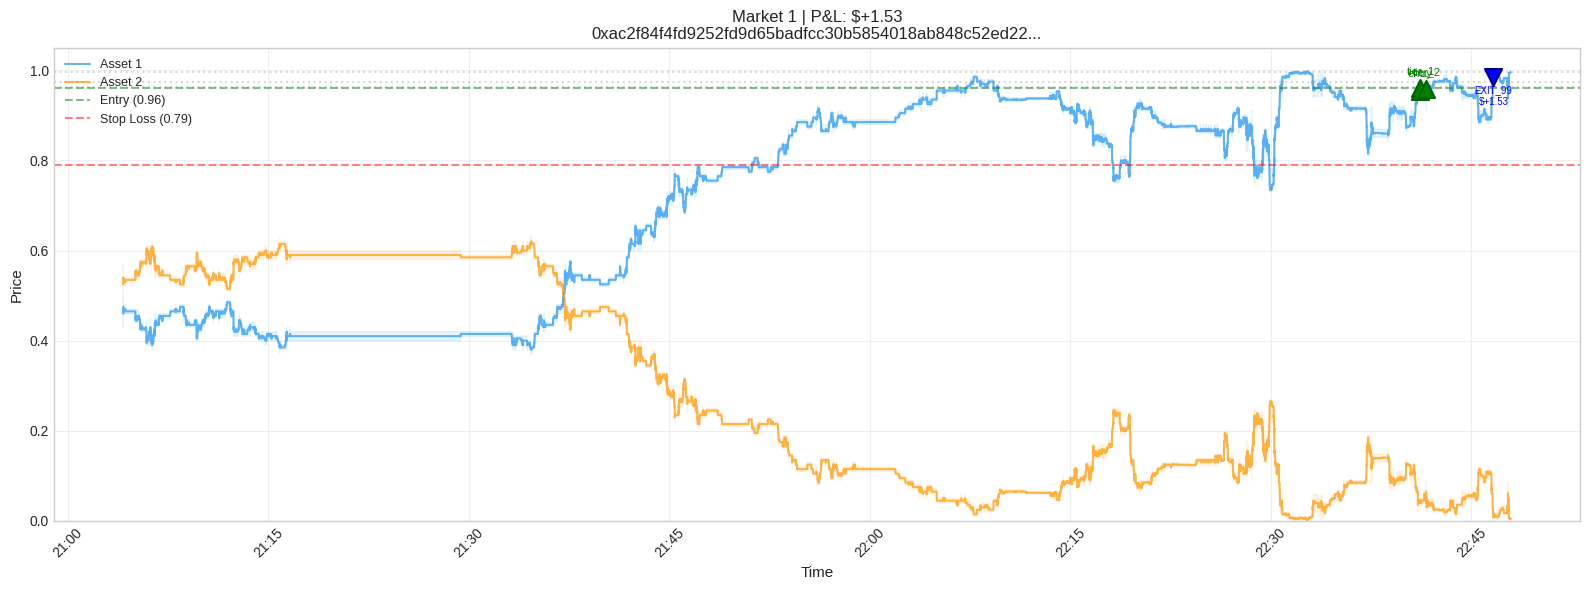

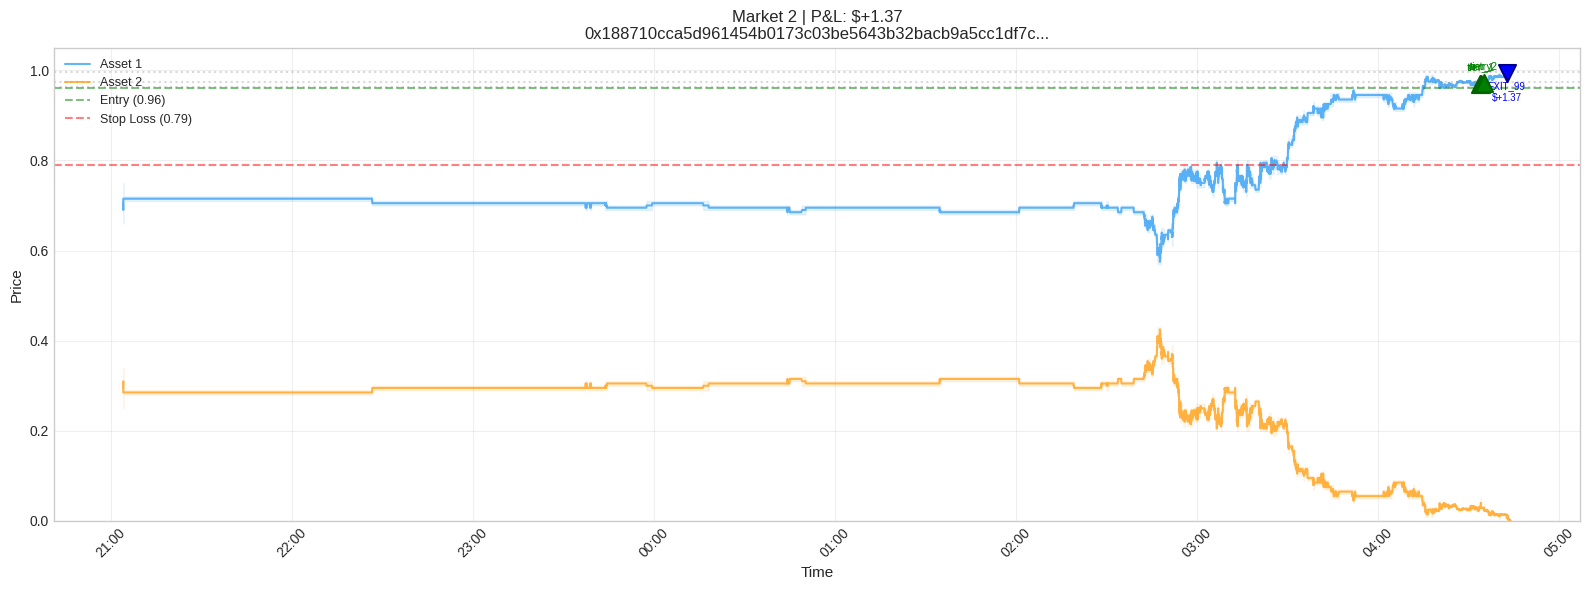

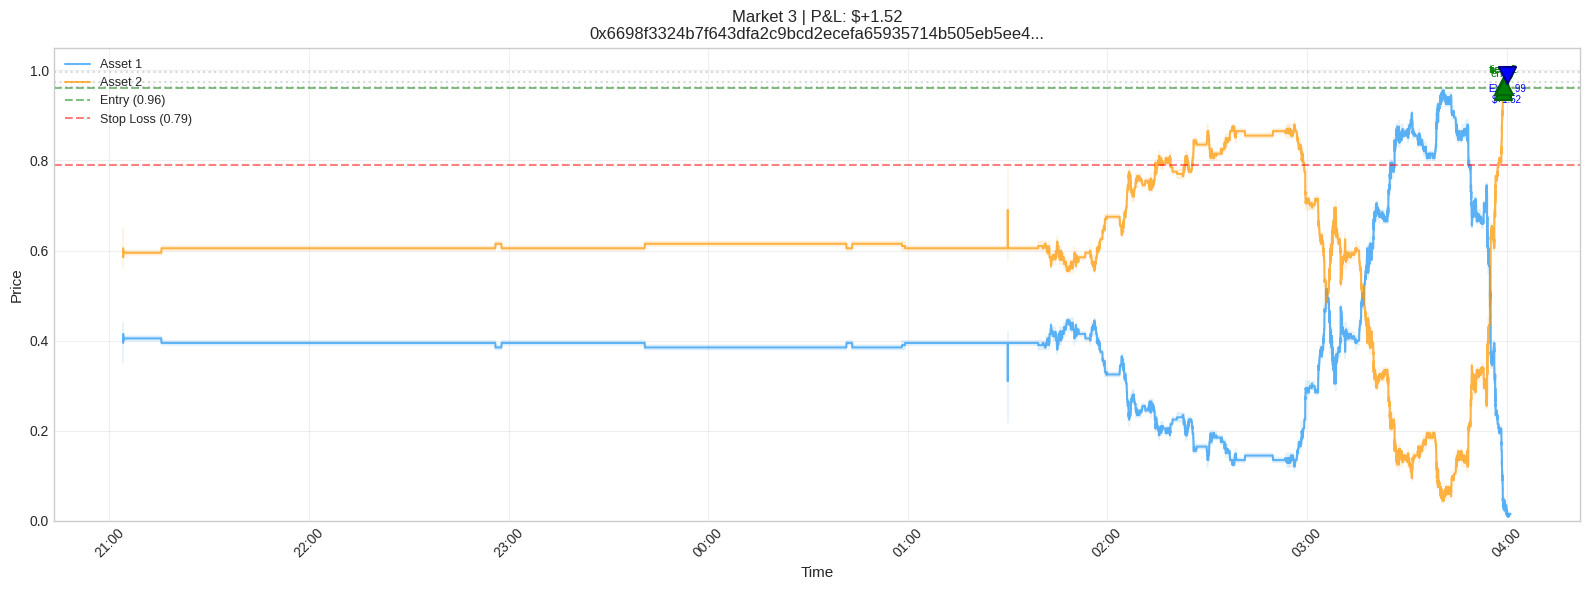

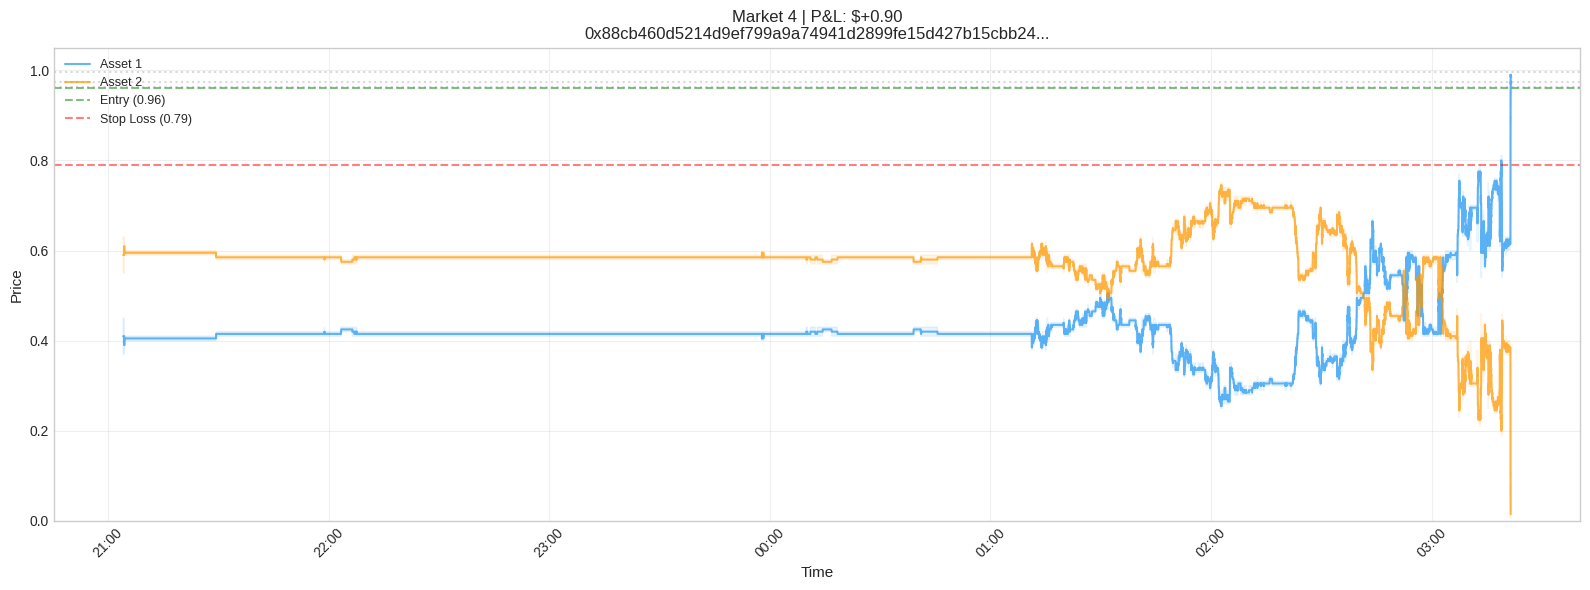

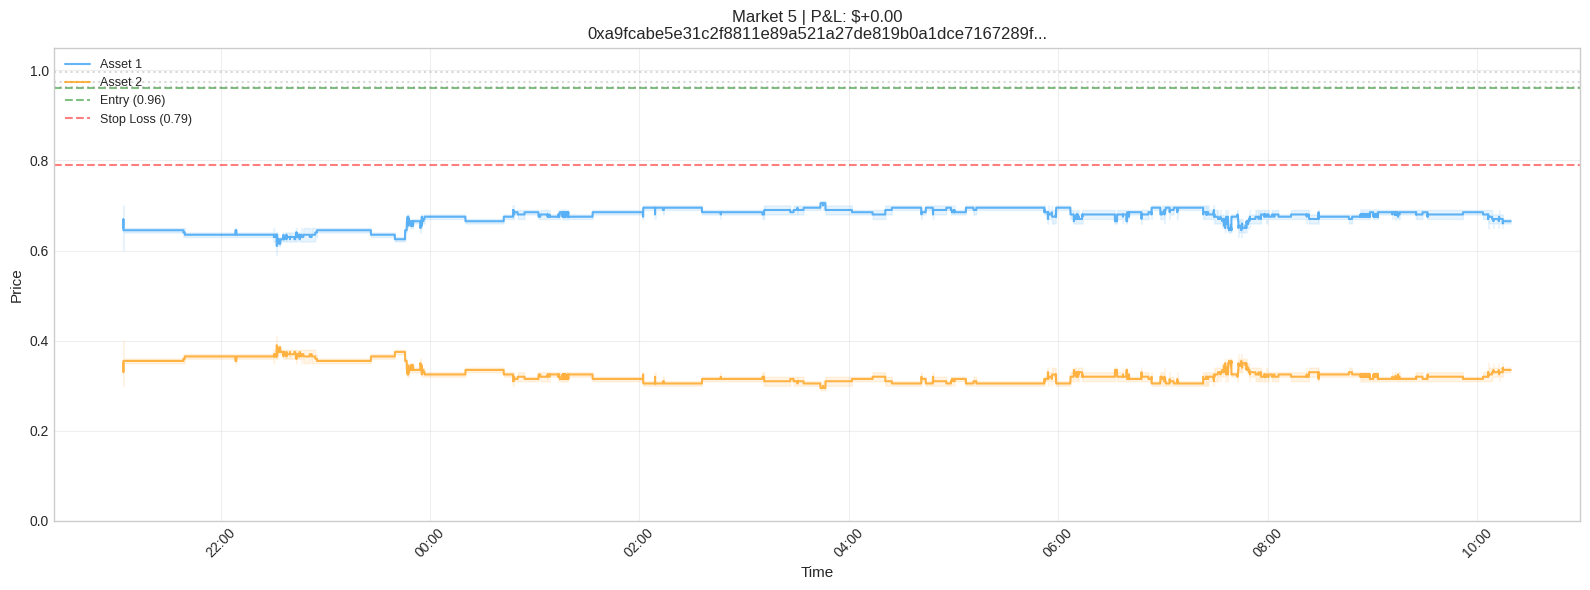

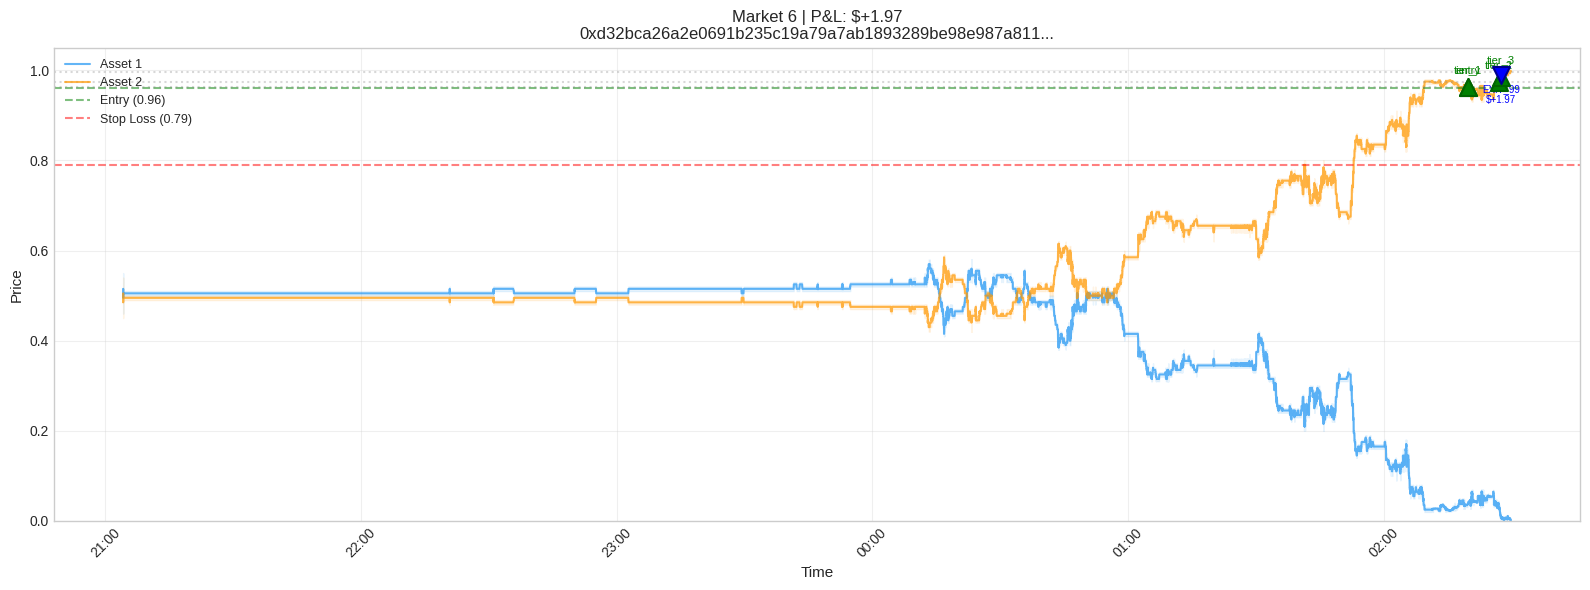

In [19]:
plot_all_markets(df, results)

---
## 6. Optuna Optimizer

Hyperparameter optimization across multiple datasets.

In [20]:
def run_optuna(
    datasets: List,
    n_trials: int = 100,
    initial_capital: float = 500,
    global_tp_pct: float = 0.07,
    resample: str = '1s',
    param_ranges: Dict = None,
    conservative: bool = False
):
    """
    Optimize strategy parameters using Optuna.

    Args:
        datasets: List of (df, known_winners, selected_markets, name) tuples
        n_trials: Number of optimization trials
        initial_capital: Starting capital per dataset
        global_tp_pct: Global take profit percentage
        resample: Resample interval
        param_ranges: Custom parameter ranges
        conservative: Use conservative ranges (entry >= 0.95)

    Returns:
        (study, best_params, per_dataset_results)
    """
    if not OPTUNA_AVAILABLE:
        raise ImportError("Optuna not installed. Run: pip install optuna")

    # Default parameter ranges
    if conservative:
        default_ranges = {
            'entry_threshold': (0.95, 0.99),
            'exit_stop_loss': (0.75, 0.92),
            'stop_loss_pct': (0.02, 0.10),
            'take_profit_pct': (0.01, 0.08),
            'cooldown_periods': (3, 15),
            'dca_tier_1': (0.96, 0.99),
            'dca_tier_2': (0.97, 0.995),
            'dca_tier_3': (0.98, 0.999),
            'weight_entry': (0.30, 0.60),
            'weight_tier_1': (0.15, 0.35),
            'weight_tier_2': (0.10, 0.25),
            'weight_tier_3': (0.05, 0.20),
        }
    else:
        default_ranges = {
            'entry_threshold': (0.60, 0.97),
            'exit_stop_loss': (0.40, 0.70),
            'stop_loss_pct': (0.05, 0.25),
            'take_profit_pct': (0.08, 0.35),
            'cooldown_periods': (3, 25),
            'dca_tier_1': (0.62, 0.99),
            'dca_tier_2': (0.64, 0.995),
            'dca_tier_3': (0.68, 0.999),
            'weight_entry': (0.08, 0.30),
            'weight_tier_1': (0.10, 0.35),
            'weight_tier_2': (0.15, 0.40),
            'weight_tier_3': (0.20, 0.45),
        }

    if param_ranges:
        default_ranges.update(param_ranges)
    ranges = default_ranges

    # Prepare datasets
    print(f"📊 Preparing {len(datasets)} dataset(s)...")
    prepared = []

    for i, item in enumerate(datasets):
        if len(item) == 4:
            data, known_winners, selected_markets, name = item
        elif len(item) == 3:
            data, known_winners, selected_markets = item
            name = f'dataset_{i+1}'
        else:
            raise ValueError(f"Dataset {i} format error")

        # Load if path
        if isinstance(data, str):
            print(f"   Loading {data}...")
            data = pd.read_parquet(data)

        data = data.copy()
        data['datetime'] = pd.to_datetime(data['datetime'])

        if selected_markets is not None:
            if isinstance(selected_markets, dict):
                selected_markets = list(selected_markets.keys())
            data = data[data['market_id'].isin(selected_markets)]

        data = data[data['ob_best_bid'].notna() & data['ob_best_ask'].notna()].copy()

        if resample:
            data['bucket'] = data['datetime'].dt.floor(resample)
            data = data.groupby(['market_id', 'asset_id', 'bucket']).last().reset_index()
            data = data.drop(columns=['datetime']).rename(columns={'bucket': 'datetime'})
            data = data.sort_values('datetime')

        n_markets = data['market_id'].nunique()
        print(f"   ✓ {name}: {len(data):,} rows, {n_markets} markets")
        prepared.append((data, known_winners, name))

    print()

    def objective(trial):
        params = {
            'entry_threshold': trial.suggest_float('entry_threshold', *ranges['entry_threshold']),
            'exit_stop_loss': trial.suggest_float('exit_stop_loss', *ranges['exit_stop_loss']),
            'stop_loss_pct': trial.suggest_float('stop_loss_pct', *ranges['stop_loss_pct']),
            'take_profit_pct': trial.suggest_float('take_profit_pct', *ranges['take_profit_pct']),
            'cooldown_periods': trial.suggest_int('cooldown_periods', *ranges['cooldown_periods']),
            'dca_tier_1': trial.suggest_float('dca_tier_1', *ranges['dca_tier_1']),
            'dca_tier_2': trial.suggest_float('dca_tier_2', *ranges['dca_tier_2']),
            'dca_tier_3': trial.suggest_float('dca_tier_3', *ranges['dca_tier_3']),
            'weight_entry': trial.suggest_float('weight_entry', *ranges['weight_entry']),
            'weight_tier_1': trial.suggest_float('weight_tier_1', *ranges['weight_tier_1']),
            'weight_tier_2': trial.suggest_float('weight_tier_2', *ranges['weight_tier_2']),
            'weight_tier_3': trial.suggest_float('weight_tier_3', *ranges['weight_tier_3']),
        }

        # Ensure tier ordering
        if not (params['entry_threshold'] < params['dca_tier_1'] < params['dca_tier_2'] < params['dca_tier_3']):
            return -1.0

        total_return = 0
        for data, known_winners, name in prepared:
            try:
                res = run_backtest(
                    data, params=params, known_winners=known_winners,
                    initial_capital=initial_capital, global_tp_pct=global_tp_pct,
                    resample=None, verbose=False
                )
                total_return += res['total_return']
            except:
                return -1.0

        return total_return / len(prepared)

    print(f"🚀 Running {n_trials} trials...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    # Results
    print(f"\n{'='*60}")
    print(f"🏆 OPTIMIZATION RESULTS")
    print(f"{'='*60}")
    print(f"Best avg return: {study.best_value*100:+.2f}%")

    print(f"\n📋 Best parameters:")
    best = study.best_params
    for k, v in sorted(best.items()):
        print(f"   {k}: {v:.4f}" if isinstance(v, float) else f"   {k}: {v}")

    # Test on each dataset
    print(f"\n📊 Per-dataset results:")
    per_dataset_results = {}

    for data, known_winners, name in prepared:
        res = run_backtest(
            data, params=best, known_winners=known_winners,
            initial_capital=initial_capital, global_tp_pct=global_tp_pct,
            resample=None, verbose=False
        )
        per_dataset_results[name] = res
        print(f"   {name}: ${res['total_pnl']:+.2f} ({res['total_return']*100:+.1f}%) "
              f"| W:{res['wins']} L:{res['losses']}")

    total_pnl = sum(r['total_pnl'] for r in per_dataset_results.values())
    avg_return = sum(r['total_return'] for r in per_dataset_results.values()) / len(per_dataset_results)
    print(f"\n   TOTAL: ${total_pnl:+.2f} | Avg return: {avg_return*100:+.1f}%")

    return study, best, per_dataset_results


if OPTUNA_AVAILABLE:
    print("✅ Optuna optimizer ready")

✅ Optuna optimizer ready


---
## 7. Market Analysis

Analyze market characteristics and threshold statistics.

In [21]:
def analyze_markets(
    df: pd.DataFrame,
    known_winners: Dict,
    thresholds: List[float] = None,
    resample: str = '5s',
    verbose: bool = True
) -> Dict:
    """
    Analyze market data for threshold performance.

    Args:
        df: DataFrame with orderbook data
        known_winners: Dict of market_id -> winning asset_id
        thresholds: Price thresholds to analyze
        resample: Resample interval
        verbose: Print output

    Returns:
        Dict with analysis results
    """
    if thresholds is None:
        thresholds = [0.85, 0.90, 0.92, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')
    df = df[df['ob_best_bid'].notna() & df['ob_best_ask'].notna()].copy()

    if resample:
        df['bucket'] = df['datetime'].dt.floor(resample)
        df = df.groupby(['market_id', 'asset_id', 'bucket']).last().reset_index()
        df = df.drop(columns=['datetime']).rename(columns={'bucket': 'datetime'})

    markets = df['market_id'].unique()

    if verbose:
        print(f"📊 Analyzing {len(markets)} markets, {len(df):,} rows")
        print(f"📅 Time range: {df['datetime'].min()} to {df['datetime'].max()}\n")

    # Threshold stats
    threshold_stats = {t: {
        'assets_touched': 0, 'winners_touched': 0, 'losers_touched': 0
    } for t in thresholds}

    for mid in markets:
        mdf = df[df['market_id'] == mid]
        winner_aid = known_winners.get(mid)

        for aid in mdf['asset_id'].unique():
            adf = mdf[mdf['asset_id'] == aid]
            max_ask = adf['ob_best_ask'].max()
            is_winner = (aid == winner_aid)

            for t in thresholds:
                if max_ask >= t:
                    threshold_stats[t]['assets_touched'] += 1
                    if is_winner:
                        threshold_stats[t]['winners_touched'] += 1
                    else:
                        threshold_stats[t]['losers_touched'] += 1

    if verbose:
        print("=" * 70)
        print("📈 THRESHOLD ANALYSIS")
        print("=" * 70)
        print(f"{'Threshold':<12} {'Assets':<10} {'Winners':<10} {'Losers':<10} {'Win Rate':<12}")
        print("-" * 70)
        for t in sorted(thresholds):
            s = threshold_stats[t]
            total = s['assets_touched']
            win_rate = s['winners_touched'] / total * 100 if total > 0 else 0
            print(f"{t:<12.2f} {total:<10} {s['winners_touched']:<10} "
                  f"{s['losers_touched']:<10} {win_rate:<11.1f}%")

    return {'threshold_stats': threshold_stats, 'n_markets': len(markets)}


print("✅ Analysis functions ready")

✅ Analysis functions ready


---
## 8. Known Winners

Market outcome data for backtesting.

In [22]:
# 24 January
known_winners_24jan = {
    '0x88cb460d5214d9ef799a9a74941d2899fe15d427b15cbb24140328514b72ffab': '42781397119150928524620980569712935893636283323356676294919480802104602608040',
    '0xd32bca26a2e0691b235c19a79a7ab1893289be98e987a811cfadc9d927df9ccd': '91882959557077986206360079185370037618383834179859904199045807600717043152693',
    '0x6698f3324b7f643dfa2c9bcd2ecefa65935714b505eb5ee4ae15c139e48a3ea3': '13882206331450371303568000116534203832428526824407877756346123225263754654563',
    '0x188710cca5d961454b0173c03be5643b32bacb9a5cc1df7cccd5eb0958308808': '103069867371701144274707916726602160059633490990003222285779377518286262505715',
    '0xac2f84f4fd9252fd9d65badfcc30b5854018ab848c52ed220b108bf0c01a59e4': '100839774769010266331661617202208847432106473005501947665369602880398232703155',
}

selected_markets_24jan = list(known_winners_24jan.keys())

In [23]:
# 25 January
known_winners_25jan = {
    '0x0ad7bfefa1318072a7718199b97c81e3815c013987400910ec4f341eab657163': '22548266195851269689477719506198642269528767995990837775232261605151563451942',
    '0x548bf24ac69dda721ac2c9f70ddf7d4907ddebfaa552b3c9d90c2ea579759850': '51674227959772201692995587953323756294034141098159045110117222361966129767794',
    '0x3b55b213f4d41ecf371a0308ea5e9bac95667b048828593908c5d6011f53c46f': '85996455898810555143401747386030485146842361772986418197315925327109740729086',
    '0xc71b8b2579a7b51d49cfda84312ae613ab5fca893659a0cc5d83116cdc689b35': '42126278325805086214134314057239966182355296066644260428412036278357258960610',
    '0x87d597755d0b8cb400ef7f1b2437a6ea5f84d25002951b676a1b783b26dad578': '17666858862007195233465506261917218863242430381450028132230016398149405665134',
}

selected_markets_25jan = list(known_winners_25jan.keys())

In [24]:
# 26 January
known_winners_26jan = {
    '0xfa2de983f8642c0f61c6c9f6890144c00569720c7ac4966fa14ae61887805119': '100867343898929430052757546050745655715685585456696690891892865600379098158025',
    '0x31ab55ffa13f6db8e57d399ea90d4efa108e4ea3ebe8254b8dd711ce0300a44b': '87800006559503182362481555183568667613755424315939426292124794493674893045177',
    '0x0ec8aba4da6ff2d822375826e5b26a77ad44475880806e3911208676c8b27189': '50360611238162519349597526846658115119614668036291381303699223838097185992619',
    '0x1fc322c68723e7d66ccf795cdb8cf229ddb02e0e44b7d92e4d7818a6a8effab1': '12538008096049809260959942696355073549474960063955610419251367912602775702371',
    '0xfdc2ca60f0240b3d309dc2aa8fc80b30121003226490859114f2a544d295f9e1': '19370786313375349944222593512059669535964487521741074120538382195117540825433',
    #'0x09aa5f4210ff3e17e65072e73bf084a1d72246ec712b8d33c4efbc958192a435': '112460056466301987895624067988030855175451380171501724318327858610989988015996',
}

selected_markets_26jan = list(known_winners_26jan.keys())

In [25]:
# 27 January
known_winners_27jan = {
    '0xdc61b928589ea4d3e97bbb80a27e84eca4f59cfa9c37319ba2a7b63199bcdf31': '114810619020440066196286636298926087160454506616717843900975576221717806376761',
    '0xa338b21f43ccf35f427c9674a0effde074d28cabb7e2358ec498a1ba049b9470': '105917824473601761478847321769933632598106021887333748710627510244193706793258',
    '0xfbbca64429c68fe60f8b7f5713cb7c2b6e3f0b72ad72ead6e30c7bd7f03d2328': '114403476857604701724608088874049221045243705059599768206726165533185920136385',
    '0x96efea44484d3752fa72dc3ca5987c2e16a006112dbbe0174730b8ad5932c98f': '518272430027893766986552798258835853433678957912568820764900306532617260527',
    '0xb358099a4d3cd1908fafa4ef492d131a4d30a41866b556ac65ea0db905ec78a1': '48924055834814888428606569679658798321783136070365706735814433351016547108906',
    '0x6cefa261bfbee131da94a3ca013886a58606ae27055175ee62910251cd9aa532': '81640735300133043464899322835663435037559272815252333754895208703479291308029',
    '0x4e99e7565b30f92229489999e659a3136632449d88fc011bd4e8cc06c484ccca': '87890321414384780337490094423156067406932290358906185528607515117644478595310',
    '0x538be58810bd07707c1e849da9b4de12dc6617739c2e87043ea9b7fb2b6266c3': '41247652063966004401306857419416685235874842651432515489339067969075836389387',
    '0xcbed61cd2f96e0137ad098dcd8941efedea6f2e304f8b786f2a177ffffa9328a': '27061289282536287632793183240411687357181345607670439418333463229431698897460',
    '0x42c36cff27c928a58f71626244fb1acebcfd963976972cc03dc46c809a8663da': '41882622457175161594434643470609594422739676193078727425608733682888208989127',
}

selected_markets_27jan = list(known_winners_27jan.keys())

print("✅ Known winners loaded")

✅ Known winners loaded


In [26]:
known_winners_1feb = {
    '0x045decb722882afaf0d7073fcee0e258157648fbb39834d79b3a5c4c87f55f5c': '47914109276976795228171596329183196073418801725090548023772993109187195119102', #bucacnners
    '0x69dd6cdc5026979f6b91432997a72a646bdbd9974c8bbc97c6fee84f9b593860': '35507679041658691421113946209792145726790636549803609308451765849153829282684', #pistons
    '0xe27314abed3ee02d34879131f9cb58ac6ae8cf99d554f8d3787f7e5891136bf0': '49451720559536207793651194331382402132359704214117870228018524488985344367475', #
    '0xc8c05c3b44e67dfa6e2e9621751df029a9e29f2b09610571a0a9f3cad5a00f31': '26112071446814965402999048891641754983996549455934167336095987299380637999450', #cavaliers
    '0x57edace77a734a5df5f27b7b9120351e6cb65c295298e1e14acf78fb3ed05ad6': '4621351331926841526016002617363536723536461848217261221656656989817918684696', #clippers
    '0x4bf5c88fd2d848ef9263100e6b71a4ad65f032ee51da6a1a7727cfa9eed96934': '88583007069540440685836742484888009905331163639550673068046284859288460643884', # knicks
    '0xdb264f66040a967e13a4de5ebdee5fcfb0f826454b4b409a807b9d7222c1cb68': '101971266276864678863554426688496696165714598981788215573271274390814686396324', #thunder
    '0xb8556936a9327f016822d938a0ca62bb9bf5a325a98a2a373d0de2f3fe13fd2f': '101962832390240355913931476340349239068949031036967665157922908391872847118001', #spurs
    '0xbaa2377f797eb0661f4457ca26bb18fe45fefffc7f686c3a76c2bc05688ca22e': '74489684361478237889335886769358759614273687619166546551579716934861841022764',#wizards
    '0xff7d45a68af8a7ec25ee7d4cf1fba33f8578087e4b8e36893452b493d13f95a1': '59325667443396724746830154919871636532815974483012166602106258099779573654373', #raptors
}

selected_markets_1feb = list(known_winners_1feb.keys())

---
## 9. Run Backtest

Example backtest execution.

In [27]:
# Define your parameters
my_params = {
    'entry_threshold': 0.7412,
    'exit_stop_loss': 0.5440,
    'stop_loss_pct': 0.1354,
    'take_profit_pct': 0.3406,
    'cooldown_periods': 21,
    'dca_tier_1': 0.7916,
    'dca_tier_2': 0.8382,
    'dca_tier_3': 0.8501,
    'weight_entry': 0.1064,
    'weight_tier_1': 0.3337,
    'weight_tier_2': 0.2735,
    'weight_tier_3': 0.2382,
}

print("📋 Parameters configured")

📋 Parameters configured


In [ ]:
results = run_backtest(df, params=my_params, known_winners=known_winners_27jan,
                       selected_markets=['0xa338b21f43ccf35f427c9674a0effde074d28cabb7e2358ec498a1ba049b9470'], verbose=True)

In [42]:
# Load data and run backtest
# Uncomment to run:

df = load_data(DATA_PATHS['01feb'])
results = run_backtest(
     df,
     params=my_params,
     known_winners=known_winners_1feb,
     selected_markets=selected_markets_1feb,
     initial_capital=500,
     resample='1s'
)

✅ Loaded 3,690,634 rows, 12 markets
   Time range: 2026-02-01 23:05:32.858000 to 2026-02-02 09:06:57.744000
📊 10 markets, 3,493,962 rows
⏱️  Resampled to 1s: 168,436 rows
   [DEBUG HEDGE] 0xbaa2377f797eb... price=0.69 entry=0.75 drop=0.06 need=0.1
   [DEBUG HEDGE] 0xbaa2377f797eb... price=0.67 entry=0.75 drop=0.08 need=0.1
   [DEBUG HEDGE] 0xbaa2377f797eb... price=0.67 entry=0.75 drop=0.08 need=0.1
   [DEBUG HEDGE] 0xbaa2377f797eb... price=0.67 entry=0.75 drop=0.08 need=0.1
   [DEBUG HEDGE] 0xbaa2377f797eb... price=0.66 entry=0.75 drop=0.09 need=0.1
   [DEBUG HEDGE] 0xbaa2377f797eb... price=0.66 entry=0.75 drop=0.09 need=0.1
🛡️ HEDGE [0xbaa2377f797eb0661f...]: SLOW_DROP_0.10_from_entry_0.75
   Bought $30.00 @ 0.37 | Main @ 0.65
🔄 PROMOTION [0xbaa2377f797eb0661f...]: HEDGE_PRICE_0.36>=0.3
   Main: $-0.78 (-14.0%) @ 0.65
   Hedge: $-0.33 (-1.1%) @ 0.36
   [DEBUG POS] 0xbaa2377f797eb... aid=7448968436 main_aid=7448968436 has_main_pos=True is_main_row=True price=0.36
   [DEBUG] Can't hedge

📊 Plotting 10 markets with trades...



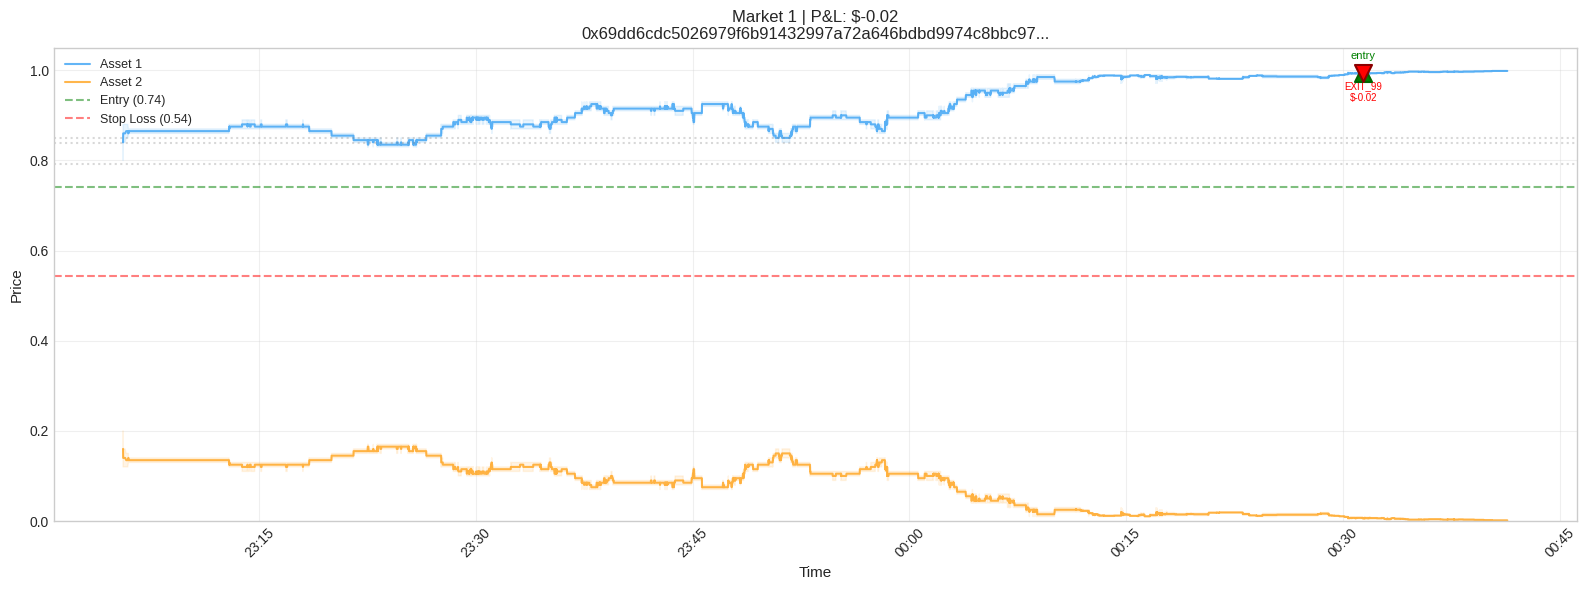

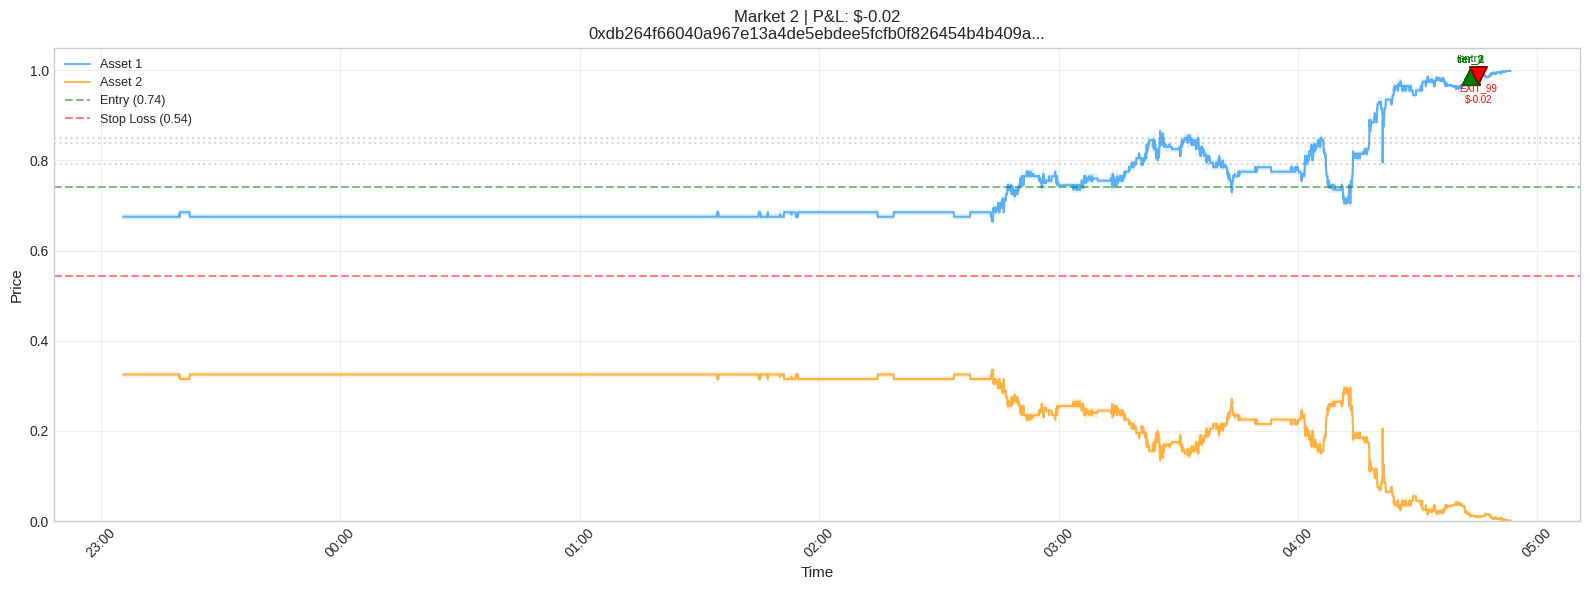

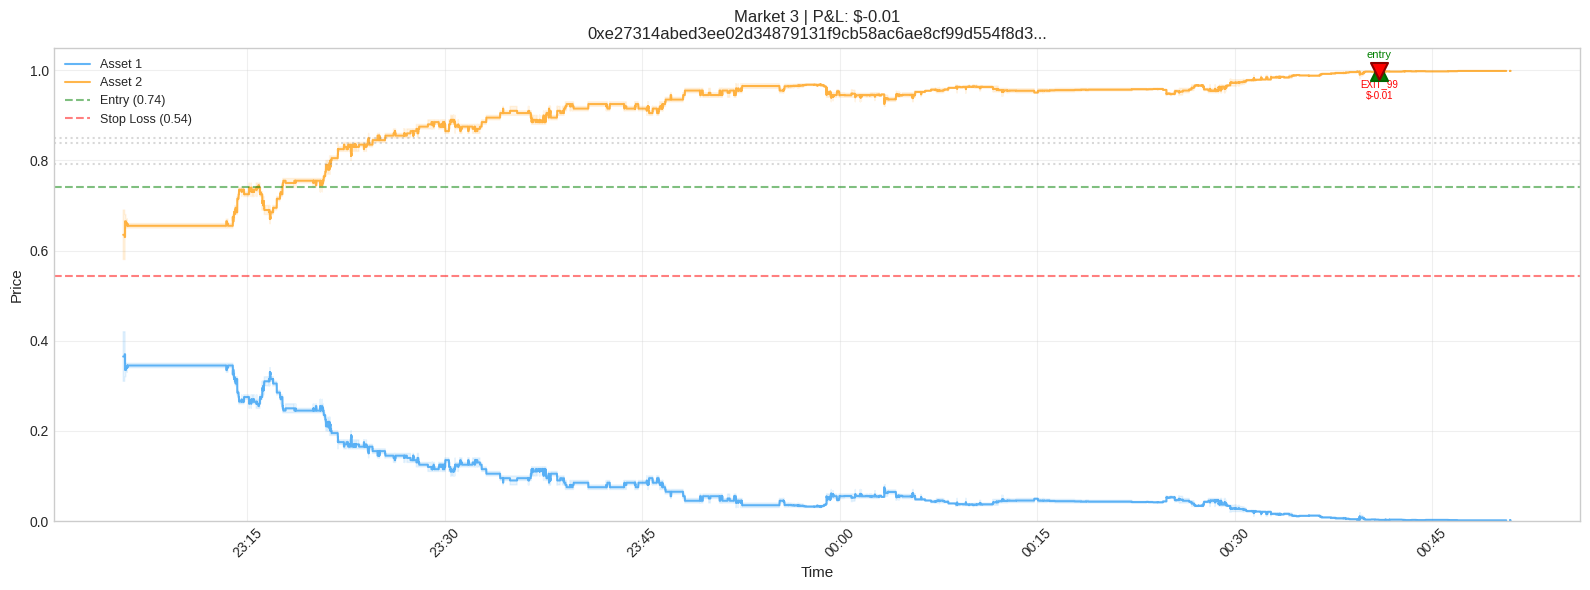

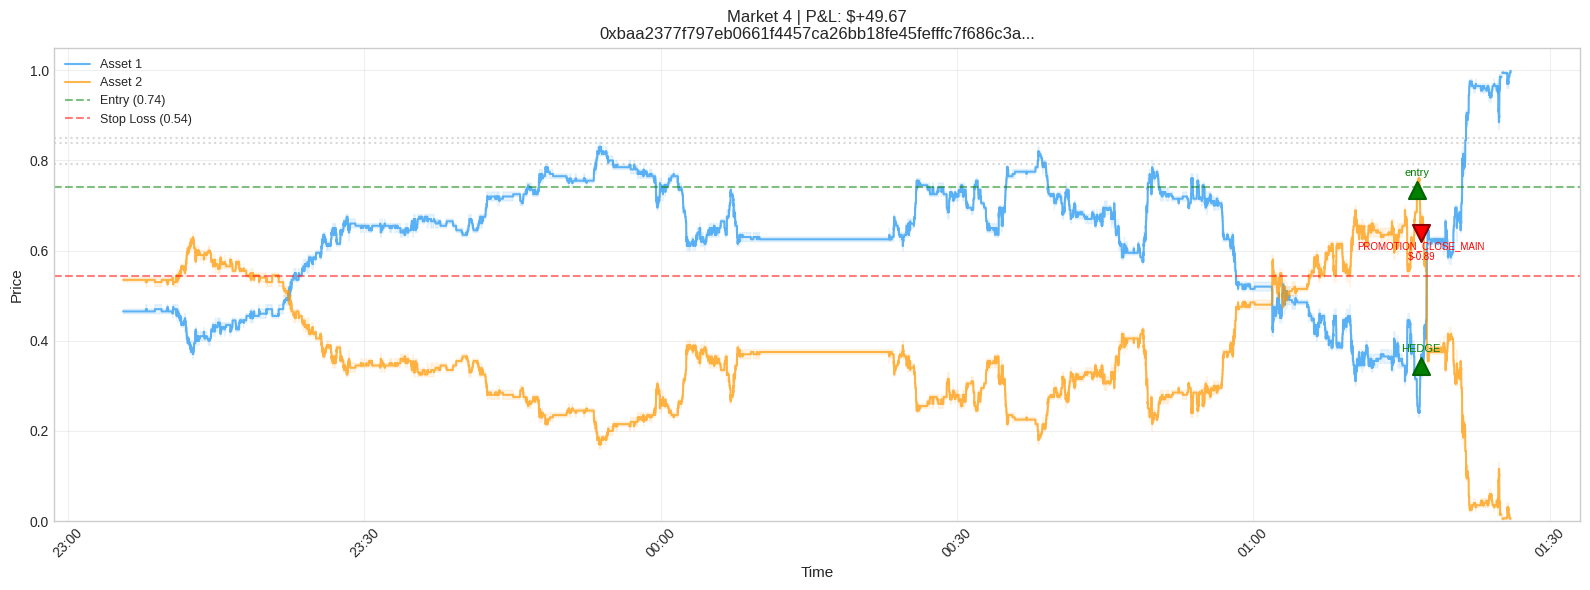

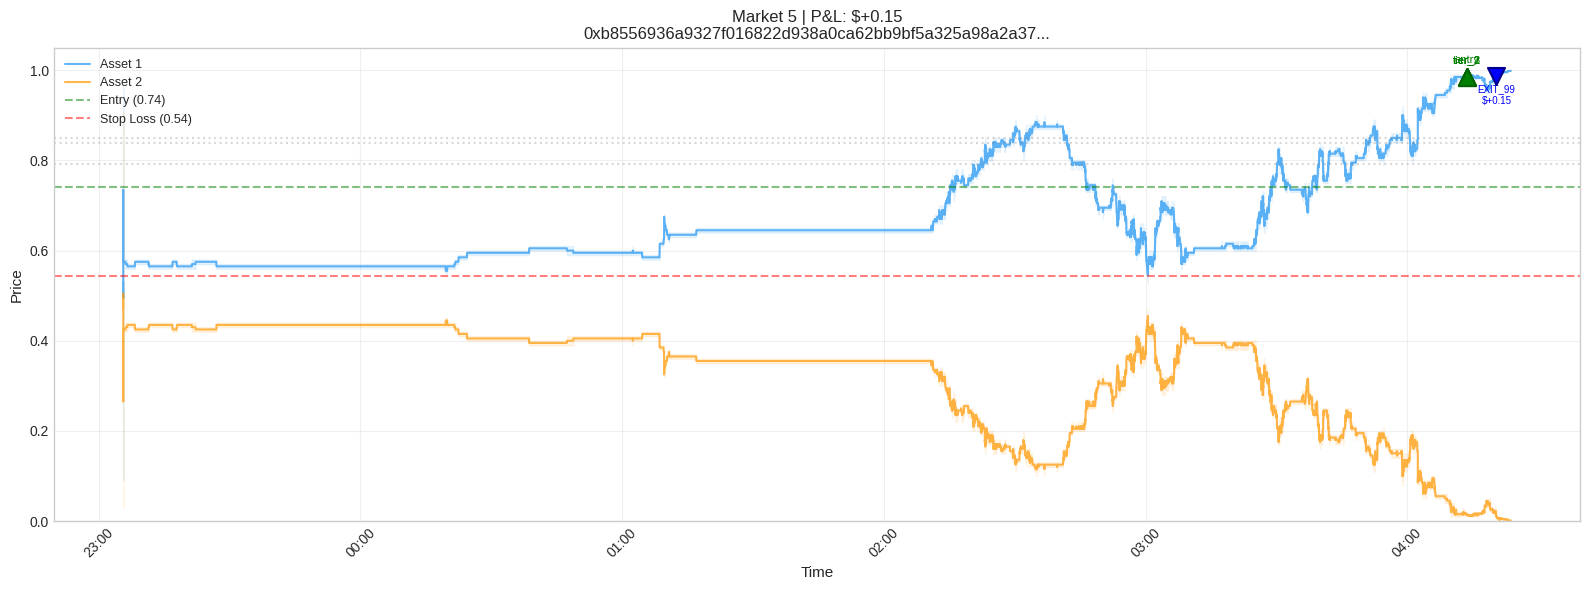

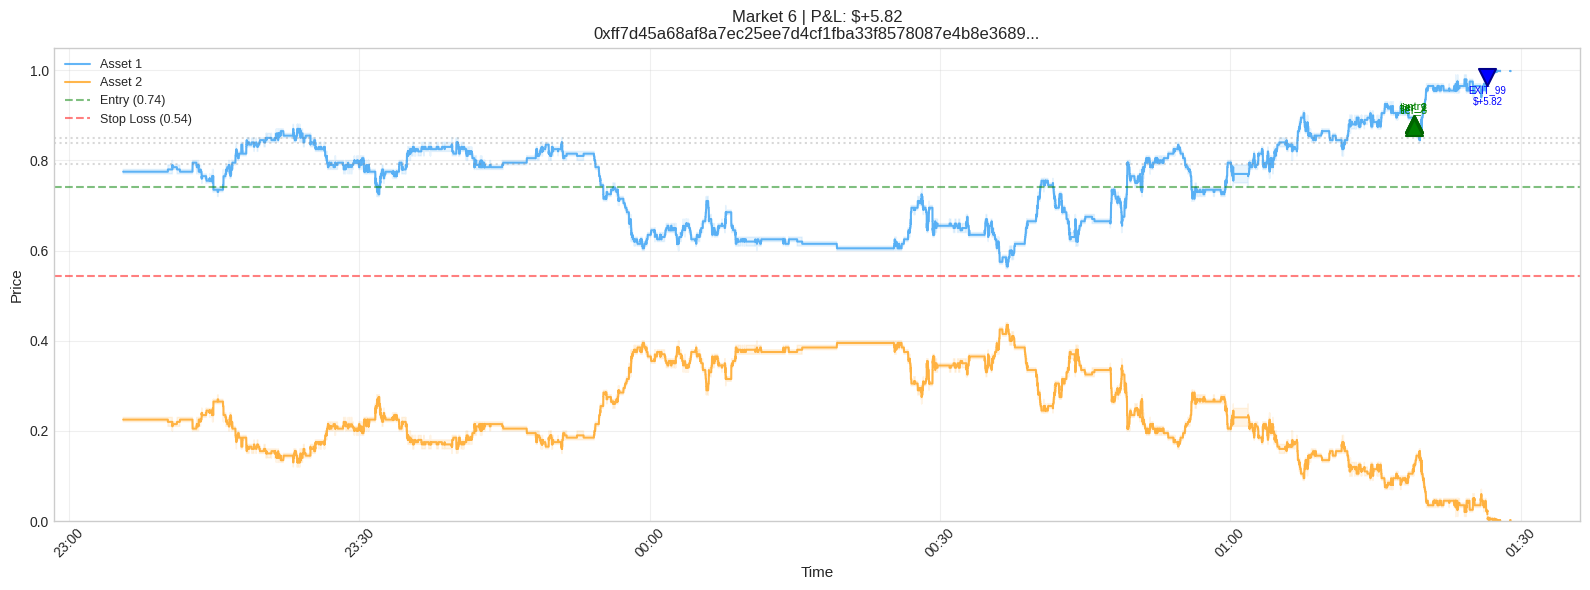

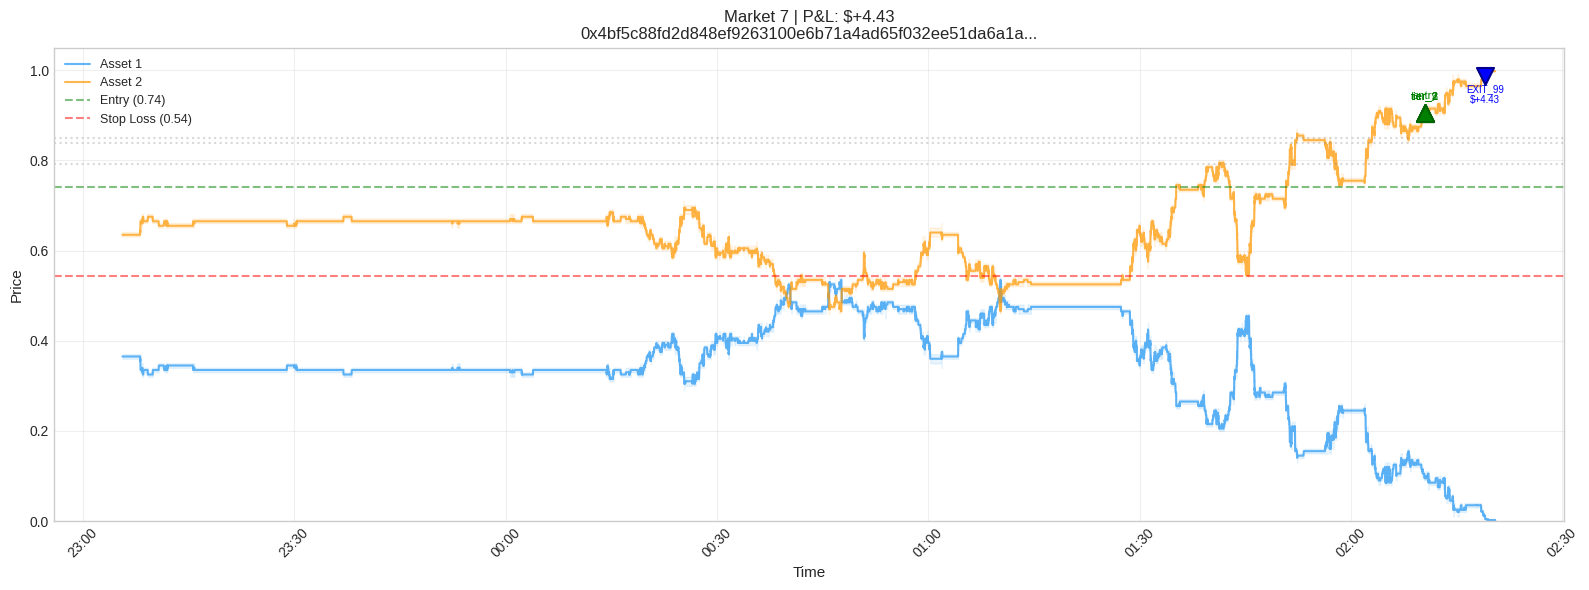

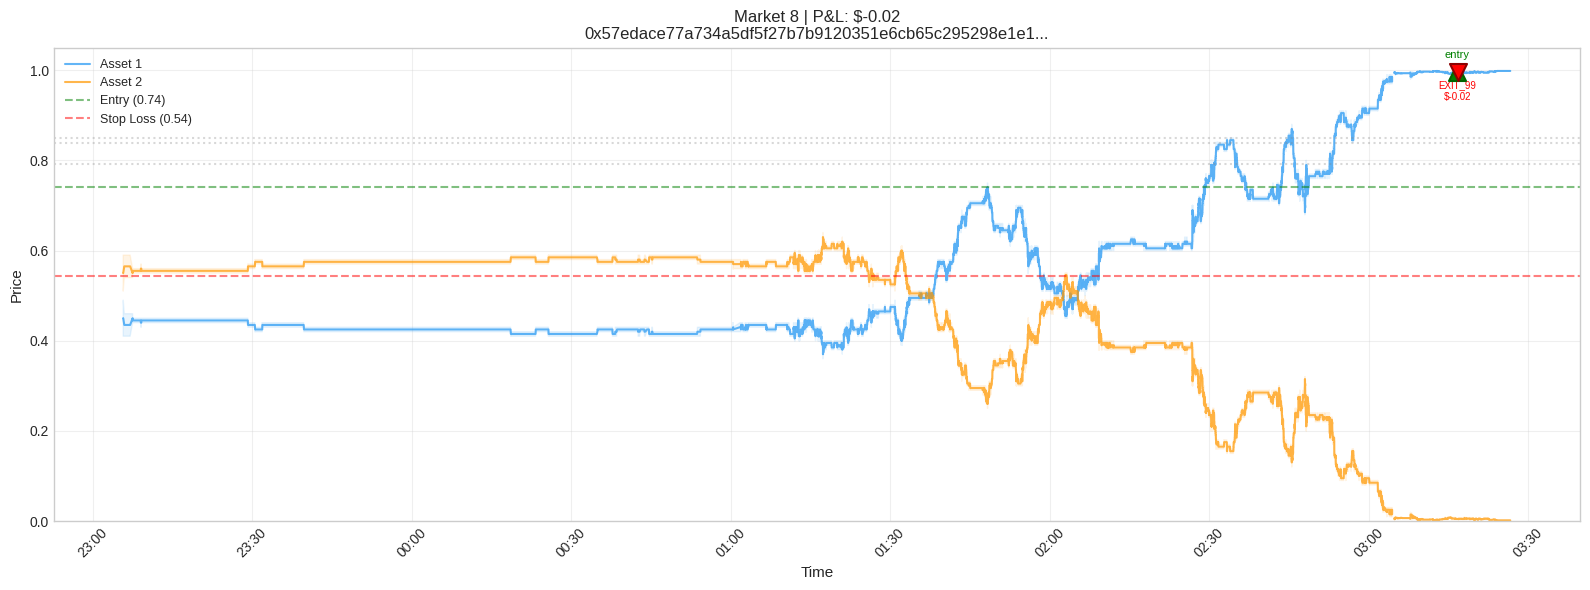

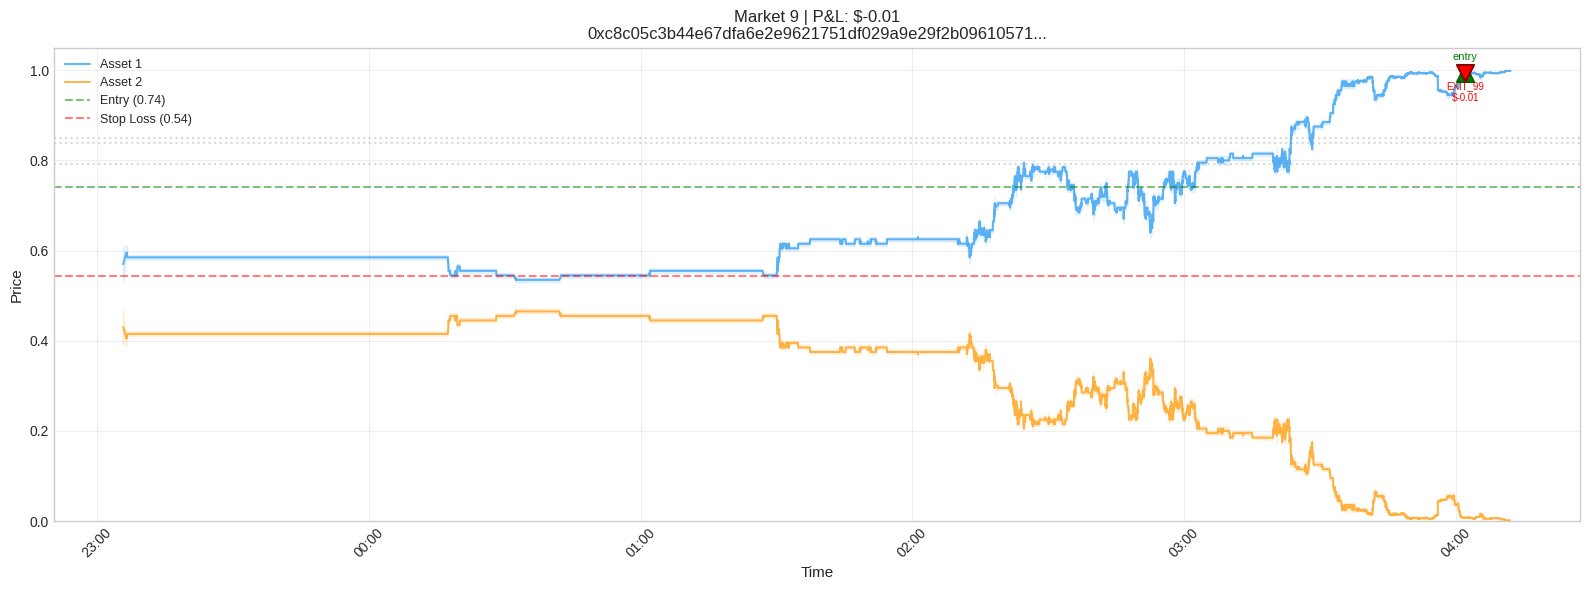

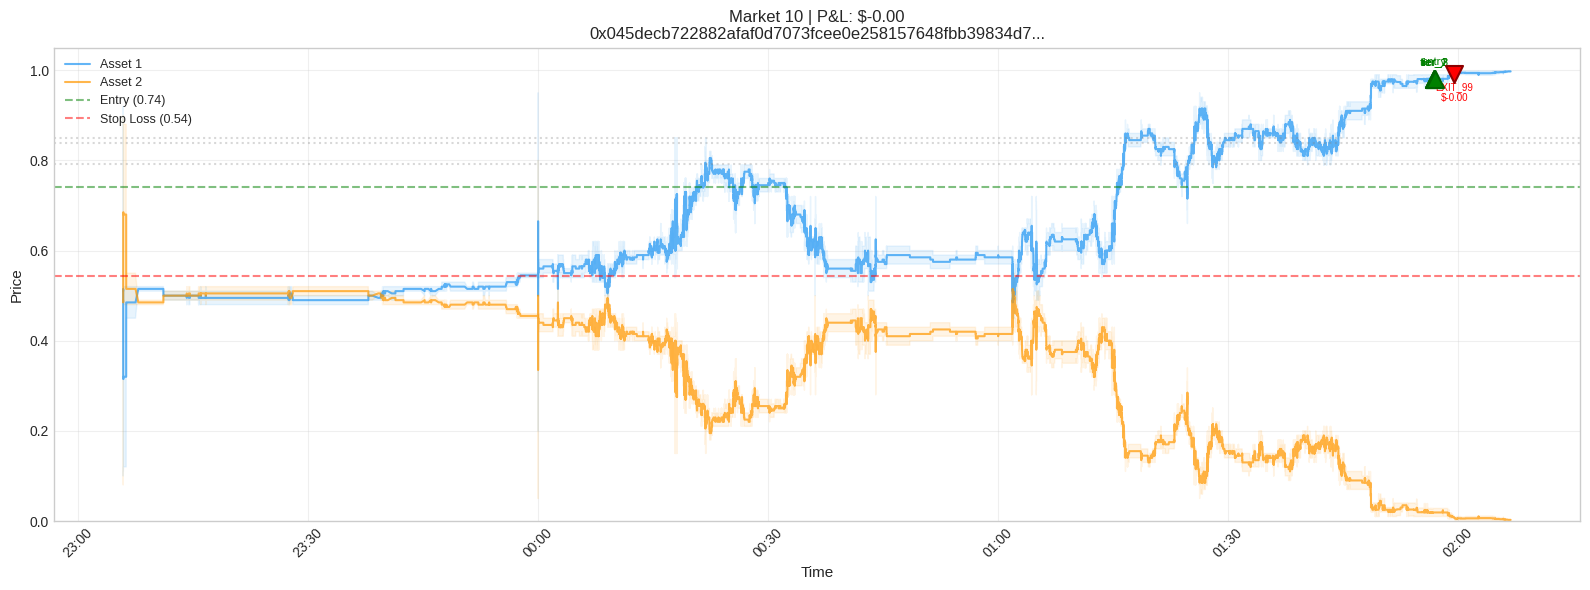

In [43]:
# Visualize results
# Uncomment after running backtest:

#plot_backtest(df, results, market_index=0)
plot_all_markets(df, results)

---
## 10. Run Optimization

Multi-dataset parameter optimization.

In [44]:
# Load all datasets for optimization
# Uncomment to run:

df_24 = load_data(DATA_PATHS['24jan'])
df_25 = load_data(DATA_PATHS['25jan'])
df_26 = load_data(DATA_PATHS['26jan'])
df_27 = load_data(DATA_PATHS['27jan'])

✅ Loaded 2,403,298 rows, 6 markets
   Time range: 2026-01-24 21:04:08.656000 to 2026-01-25 10:19:16.502000
✅ Loaded 1,817,932 rows, 6 markets
   Time range: 2026-01-25 22:52:30.696000 to 2026-01-26 08:30:45.252000
✅ Loaded 2,060,124 rows, 6 markets
   Time range: 2026-01-26 20:18:29.891000 to 2026-01-27 06:50:48.137000
✅ Loaded 3,609,174 rows, 15 markets
   Time range: 2026-01-27 23:56:45.623000 to 2026-01-28 08:46:50.488000


In [45]:
# Define datasets for optimization
datasets = [
    (df_24, known_winners_24jan, selected_markets_24jan, '24jan'),
    (df_25, known_winners_25jan, selected_markets_25jan, '25jan'),
    (df_26, known_winners_26jan, selected_markets_26jan, '26jan'),
    (df_27, known_winners_27jan, selected_markets_27jan, '27jan'),
]

In [46]:
# Run standard optimization
study, best_params, results = run_optuna(datasets, n_trials=200)

📊 Preparing 4 dataset(s)...
   ✓ 24jan: 121,826 rows, 5 markets
   ✓ 25jan: 101,804 rows, 5 markets
   ✓ 26jan: 149,456 rows, 5 markets
   ✓ 27jan: 138,454 rows, 10 markets

🚀 Running 200 trials...


  0%|          | 0/200 [00:00<?, ?it/s]


🏆 OPTIMIZATION RESULTS
Best avg return: +6.41%

📋 Best parameters:
   cooldown_periods: 21
   dca_tier_1: 0.7916
   dca_tier_2: 0.8382
   dca_tier_3: 0.8501
   entry_threshold: 0.7412
   exit_stop_loss: 0.5440
   stop_loss_pct: 0.1354
   take_profit_pct: 0.3406
   weight_entry: 0.1064
   weight_tier_1: 0.3337
   weight_tier_2: 0.2735
   weight_tier_3: 0.2382

📊 Per-dataset results:
   24jan: $+35.18 (+7.0%) | W:4 L:3
   25jan: $+35.69 (+7.1%) | W:1 L:2
   26jan: $+22.03 (+4.4%) | W:3 L:2
   27jan: $+35.26 (+7.1%) | W:7 L:2

   TOTAL: $+128.17 | Avg return: +6.4%


In [ ]:
# Run conservative optimization (entry >= 0.95)
# study, best_params, results = run_optuna(datasets, n_trials=100, conservative=True)

---
## Quick Reference

```python
# Load data
df = load_data('path/to/parquet')
list_markets(df)

# Run backtest
results = run_backtest(df, params=my_params, known_winners=known_winners_25jan)

# Visualize
plot_market(df, market_index=0)           # Simple price plot
plot_backtest(df, results, market_index=0) # With trade markers
plot_all_markets(df, results)              # All markets

# Optimize
study, best, results = run_optuna(datasets, n_trials=100)

# Analyze
analyze_markets(df, known_winners)
```